No GPU available, using the CPU instead.


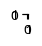

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

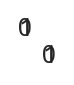

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


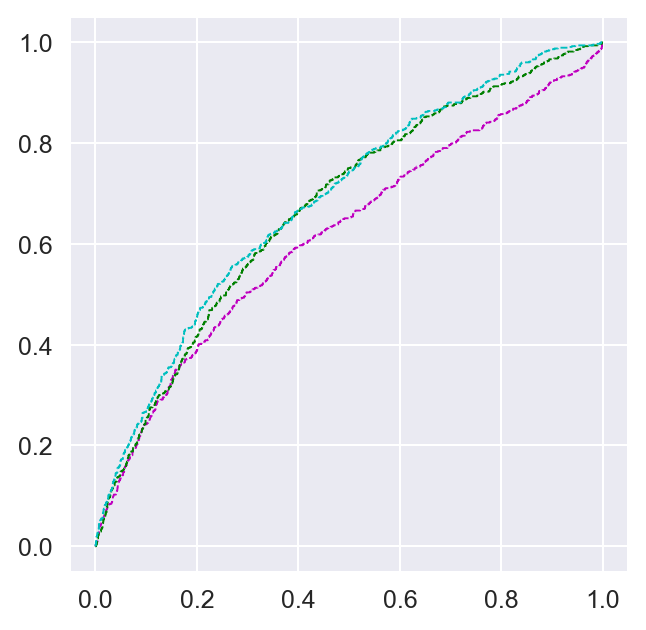

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

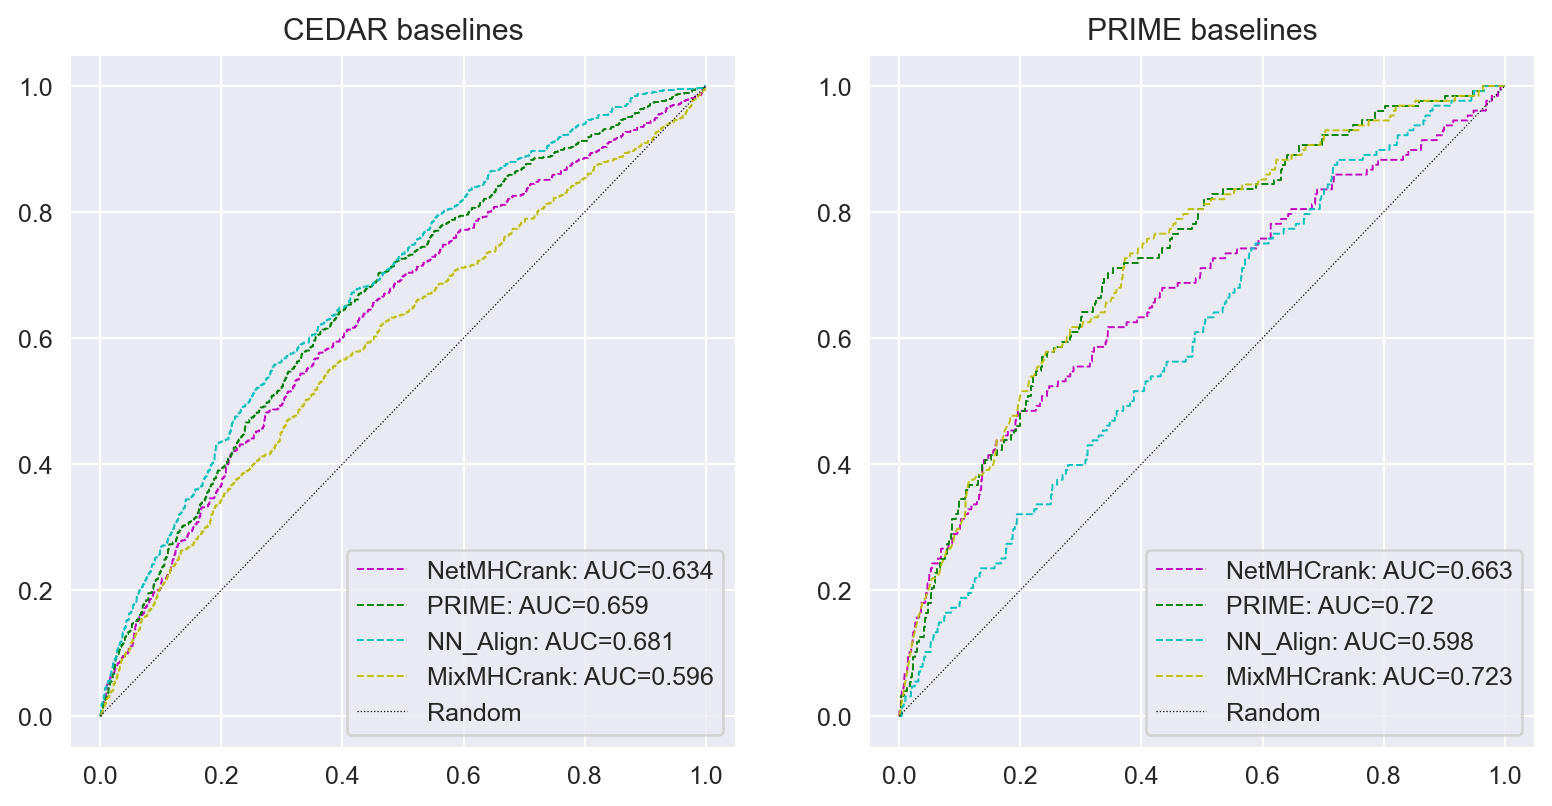

In [7]:
f,a = plt.subplots(1,2, figsize=(10.5,5))
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
a[0].set_title('CEDAR baselines')
a[1].set_title('PRIME baselines')
a[0].legend()
a[1].legend()

In [454]:
from sklearn.metrics import roc_auc_score
# Rechecking which NNalign file gave the baseline AUCs
nndir = '../../nnalign_cedar/baseline/output_baseline/221115_cedar_related.pep_27756/221115_cedar_related.pep_27756.lg6.sorted.pred'
nnalign = pd.read_csv(nndir, sep='\t', comment='#')
print('Motif len=6, CEDAR AUC: ', round(roc_auc_score(nnalign['Measure'].astype(int), nnalign['Prediction'].values),4))
nnalign_pred_prime=pd.read_csv('../../nnalign_cedar/output/nnalign_trainset_CEDAR.evalset_PRIME.txt',  sep='\t', comment='#')
print('Same model, eval on PRIME:', round(roc_auc_score(nnalign_pred_prime['Measure'].astype(int), nnalign_pred_prime['Prediction'].values),4))


nndir = '../../nnalign_cedar/baseline/output_baseline/221115_cedar_related.pep_9059/221115_cedar_related.pep_9059.lg8.sorted.pred'
nnalign = pd.read_csv(nndir, sep='\t', comment='#')
nnalign_pred_prime=pd.read_csv('../../nnalign_cedar/output/nnalign_modelLen8_trainset_CEDAR.evalset_PRIME.txt', sep='\t', comment='#')
print('\n\n\n\nMotif len=8, CEDAR AUC: ', round(roc_auc_score(nnalign['Measure'].astype(int), nnalign['Prediction'].values),4))
print('Same model, eval on PRIME:', round(roc_auc_score(nnalign_pred_prime['Measure'].astype(int), nnalign_pred_prime['Prediction'].values),4))

Motif len=6, CEDAR AUC:  0.6775
Same model, eval on PRIME: 0.6745




Motif len=8, CEDAR AUC:  0.6811
Same model, eval on PRIME: 0.6596


# Recheck all mutation scores etc and RESAVE datasets...

In [17]:
from src.mutation_tools import get_blsm_mutation_score, get_mutation_score

In [24]:
# How tf could this one be different???
cedar_related['ratio_rank'] = cedar_related['EL_rank_wt'] / cedar_related['EL_rank_mut']
prime_related['ratio_rank'] = prime_related['EL_rank_wt'] / prime_related['EL_rank_mut']
ibel['ratio_rank'] = ibel['EL_rank_wt'] / ibel['EL_rank_mut']

In [29]:
get_blsm_mutation_score??

Signature: get_blsm_mutation_score(mutation_positions, mutant, wildtype)
Source:   
def get_blsm_mutation_score(mutation_positions, mutant, wildtype):
    """
    Done as the log of the sum of mutation scores
    """
    positions = [int(x) for x in mutation_positions.split(',')]
    # print(positions, mutant, wildtype, type(positions[0]), type(mutant), mutant[positions[0]], wildtype[positions[0]])
    # Here take sum and not product because might be set to zero
    score = np.sum([BL62_MUT[mutant[x]][wildtype[x]] for x in positions])
    if score == -np.inf or score == np.nan:
        return -1
    else:
        return score
File:      ~/Documents/code/cedar/src/mutation_tools.py
Type:      function


In [28]:
get_mutation_score??

Signature: get_mutation_score(mutation_positions, mutant, wildtype)
Source:   
def get_mutation_score(mutation_positions, mutant, wildtype):
    """
    Done as the log of the sum of mutation scores
    """

    if mutant==wildtype:
        return 0
    positions = [int(x) for x in mutation_positions.split(',')]
    # Here take sum and not product because might be set to zero
    score = np.sum([MUT_MATRIX[mutant[x]][wildtype[x]] for x in positions])
    if score == -np.inf or score == np.nan:
        return -1
    else:
        return score
File:      ~/Documents/code/cedar/src/mutation_tools.py
Type:      function


In [30]:
cedar_related.columns

Index(['Peptide', 'HLA', 'EL_rank_mut', 'agg_label', 'fold', 'EL_rank_wt',
       'PMIDs', 'Peptide_mut', 'Peptide_wt', 'Pos_mut', 'Pos_wt',
       'Related Object_Ending Position', 'Related Object_Starting Position',
       'anchor_mutation', 'binder', 'blsm_mut_score', 'core',
       'core_blsm_mut_score', 'core_mut', 'core_mutation_position',
       'core_mutation_score', 'core_wt', 'dissimilarity_score', 'icore',
       'icore_mut', 'icore_wt', 'label', 'len', 'len_icore_mut',
       'len_icore_wt', 'len_pep_mut', 'len_pep_wt', 'len_wt', 'mhc_anchor',
       'mut_wt_sim', 'mutation_position', 'mutation_score', 'mutation_type',
       'percentage_pos', 'ratio_rank', 'responses', 'total_count', 'trainset',
       'trueHLA_EL_rank', 'wild_type', 'wt_EL_rank', 'wt_core', 'wt_true',
       'aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point',
       'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8'],
      dtype='object')

In [34]:
print(any(cedar_related['mutation_score'] != cedar_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(prime_related['mutation_score'] != prime_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(ibel['mutation_score'] != ibel.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))

False
False
False


In [35]:
print(any(cedar_related['core_mutation_score'] != cedar_related.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(prime_related['core_mutation_score'] != prime_related.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(ibel['core_mutation_score'] != ibel.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))

False
False
False


In [37]:
print(any(cedar_related['blsm_mut_score'] != cedar_related.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(prime_related['blsm_mut_score'] != prime_related.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(ibel['blsm_mut_score'] != ibel.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))

False
False
False


In [38]:
print(any(cedar_related['core_blsm_mut_score'] != cedar_related.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(prime_related['core_blsm_mut_score'] != prime_related.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(ibel['core_blsm_mut_score'] != ibel.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))

False
False
False


# Redo CEDAR training with random split instead of partitions

In [8]:
top_hlas = list(map(lambda x: 'HLA-'+x, ['A0201', 'A1101', 'A2402', 'B0702', 'B1501', 'B3501']))

In [16]:
for hla in top_hlas:
    print('\n',hla)
    cd = cedar_related.query('HLA==@hla')
    pr = prime_related.query('HLA==@hla')
    print(f"CEDAR:\tPos:{len(cd.query('agg_label==1'))}\tNeg:{len(cd.query('agg_label==0'))}\tRatio:{round(len(cd.query('agg_label==1'))/len(cd.query('agg_label==0')),3)}")
    print(f"PRIME:\tPos:{len(pr.query('agg_label==1'))}\tNeg:{len(pr.query('agg_label==0'))}\tRatio:{round(len(pr.query('agg_label==1'))/len(pr.query('agg_label==0')),3)}")

print('rest')
cd = cedar_related.query('HLA not in @top_hlas')
pr = prime_related.query('HLA not in @top_hlas')
print(f"CEDAR:\tPos:{len(cd.query('agg_label==1'))}\tNeg:{len(cd.query('agg_label==0'))}\tRatio:{round(len(cd.query('agg_label==1'))/len(cd.query('agg_label==0')),3)}")
print(f"PRIME:\tPos:{len(pr.query('agg_label==1'))}\tNeg:{len(pr.query('agg_label==0'))}\tRatio:{round(len(pr.query('agg_label==1'))/len(pr.query('agg_label==0')),3)}")
    


 HLA-A0201
CEDAR:	Pos:311	Neg:857	Ratio:0.363
PRIME:	Pos:36	Neg:802	Ratio:0.045

 HLA-A1101
CEDAR:	Pos:30	Neg:222	Ratio:0.135
PRIME:	Pos:13	Neg:502	Ratio:0.026

 HLA-A2402
CEDAR:	Pos:28	Neg:266	Ratio:0.105
PRIME:	Pos:6	Neg:129	Ratio:0.047

 HLA-B0702
CEDAR:	Pos:21	Neg:286	Ratio:0.073
PRIME:	Pos:5	Neg:204	Ratio:0.025

 HLA-B1501
CEDAR:	Pos:17	Neg:132	Ratio:0.129
PRIME:	Pos:5	Neg:213	Ratio:0.023

 HLA-B3501
CEDAR:	Pos:15	Neg:94	Ratio:0.16
PRIME:	Pos:10	Neg:156	Ratio:0.064
rest
CEDAR:	Pos:209	Neg:545	Ratio:0.383
PRIME:	Pos:53	Neg:975	Ratio:0.054


In [42]:
from sklearn.model_selection import StratifiedKFold
cedar_related_randomfold = cedar_related.copy()
skf = StratifiedKFold(10, random_state=13, shuffle=True)

for i, (train_idx, test_idx) in enumerate(skf.split(X=cedar_related_randomfold['Peptide'].values,
                                                    y=cedar_related_randomfold['agg_label'].values,
                                                    groups=cedar_related_randomfold['agg_label'].values)):
    cedar_related_randomfold.iloc[test_idx, list(cedar_related_randomfold.columns).index('fold')] = i
            
all(cedar_related_randomfold['fold'] == cedar_related['fold'])

False

In [82]:
cedar_related_randomfold.to_csv('../data/mutant/221222_cedar_related_random10fold.csv', index=False)

# Remake dataset : A11 + Rest, vs the other top HLAS

In [78]:
from src.partition_tools import pipeline_stratified_kfold

In [76]:
top_noa11 = list(filter(lambda x: 'A1101' not in x, top_hlas))
cedar_a11_rest = cedar_related.query('HLA not in @top_noa11').sort_values('Peptide', ascending=True).reset_index(drop=True)
cedar_tops = cedar_related.query('HLA in @top_noa11').sort_values('Peptide', ascending=True).reset_index(drop=True)
len(cedar_a11_rest), len(cedar_tops), len(cedar_related), len(cedar_a11_rest)+len(cedar_tops)

(1006, 2027, 3033, 3033)

In [77]:
cedar_a11_rest.to_csv('../../kern_dist/data/221223_cedar_a11_rest.pep',index=False,header=False,columns=['Peptide'])
cedar_tops.to_csv('../../kern_dist/data/221223_cedar_tops.pep',index=False,header=False,columns=['Peptide'])

In [81]:
cedar_a11_rest_fold = pipeline_stratified_kfold('../../kern_dist/out/221223_cedar_a11_rest.pep_0.9.out', cedar_a11_rest, k=10, shuffle=True, seed=13)
cedar_a11_rest.to_csv('../data/mutant/221223_cedar_a11_rest_10fold.csv', index=False)
cedar_tops_fold = pipeline_stratified_kfold('../../kern_dist/out/221223_cedar_tops.pep_0.9.out', cedar_tops, k=10, shuffle=True, seed=13)
cedar_tops.to_csv('../data/mutant/221223_cedar_tops_10fold.csv', index=False)

start 1006
read hobohm 833 182
strat kfold unique 833 182
manually reassign identical 833 182
manually reassign related 833 182
concat 1015
merge 1015
drop duplicated 1006
start 2027
read hobohm 1591 493
strat kfold unique 1591 493
manually reassign identical 1591 493
manually reassign related 1591 493
concat 2084
merge 2084
drop duplicated 2027


## Save for Gibbs

In [409]:
cedar_a11 = cedar_related.query('HLA=="HLA-A1101"')
cedar_rest = cedar_related.query('HLA not in @top_hlas')

In [411]:
cedar_a11.query('agg_label==1').to_csv('../../gibbs_runs/data/230103_cedar_a11_pos.pep', columns = ['Peptide'],
                                      index=False, header=False)
cedar_a11.query('agg_label==0').to_csv('../../gibbs_runs/data/230103_cedar_a11_neg.pep', columns = ['Peptide'],
                                      index=False, header=False)
cedar_a11.to_csv('../../gibbs_runs/data/230103_cedar_a11.pep', columns = ['Peptide'],
                index=False, header=False)

cedar_rest.query('agg_label==1').to_csv('../../gibbs_runs/data/230103_cedar_rest_pos.pep', columns = ['Peptide'],
                                       index=False, header=False)
cedar_rest.query('agg_label==0').to_csv('../../gibbs_runs/data/230103_cedar_rest_neg.pep', columns = ['Peptide'],
                                       index=False, header=False)
cedar_rest.to_csv('../../gibbs_runs/data/230103_cedar_rest.pep', columns = ['Peptide'],
                 index=False, header=False)

In [414]:
len(cedar_rest)+len(cedar_a11), len(cedar_rest), len(cedar_a11)

(1006, 754, 252)

# Remake full dataset without A1101

In [48]:
cedar_related_noa11 = cedar_related.query('HLA!="HLA-A1101"').sort_values('Peptide', ascending=True).reset_index(drop=True)

In [49]:
cedar_related_noa11.to_csv('../../kern_dist/data/221223_cedar_noa1101.pep', columns = ['Peptide'], index=False,header=False)

In [50]:
from src.partition_tools import pipeline_stratified_kfold
cedar_related_noa11_fold = pipeline_stratified_kfold('../../kern_dist/out/221223_cedar_noa1101.pep_0.9.out',
                                                     cedar_related_noa11, seed=13, k=10, shuffle=True, elrank_col='EL_rank_mut')

start 2781
read hobohm 2237 611
strat kfold unique 2237 611
manually reassign identical 2237 611
manually reassign related 2237 611
concat 2848
merge 2848
drop duplicated 2781


In [51]:
cedar_related_noa11_fold.to_csv('../data/mutant/221223_cedar_noa1101_10fold.csv', index=False)

# check feats in top HLA

In [58]:
from src.data_processing import get_aa_properties
_, aa_cols = get_aa_properties(cedar_related.sample(3))

In [67]:
cedar_tmp = cedar_related.copy()
cedar_tmp.loc[cedar_tmp.query('HLA not in @top_hlas').index,'HLA']='non_top'

prime_tmp = prime_related.copy()
prime_tmp.loc[prime_tmp.query('HLA not in @top_hlas').index,'HLA']='non_top'

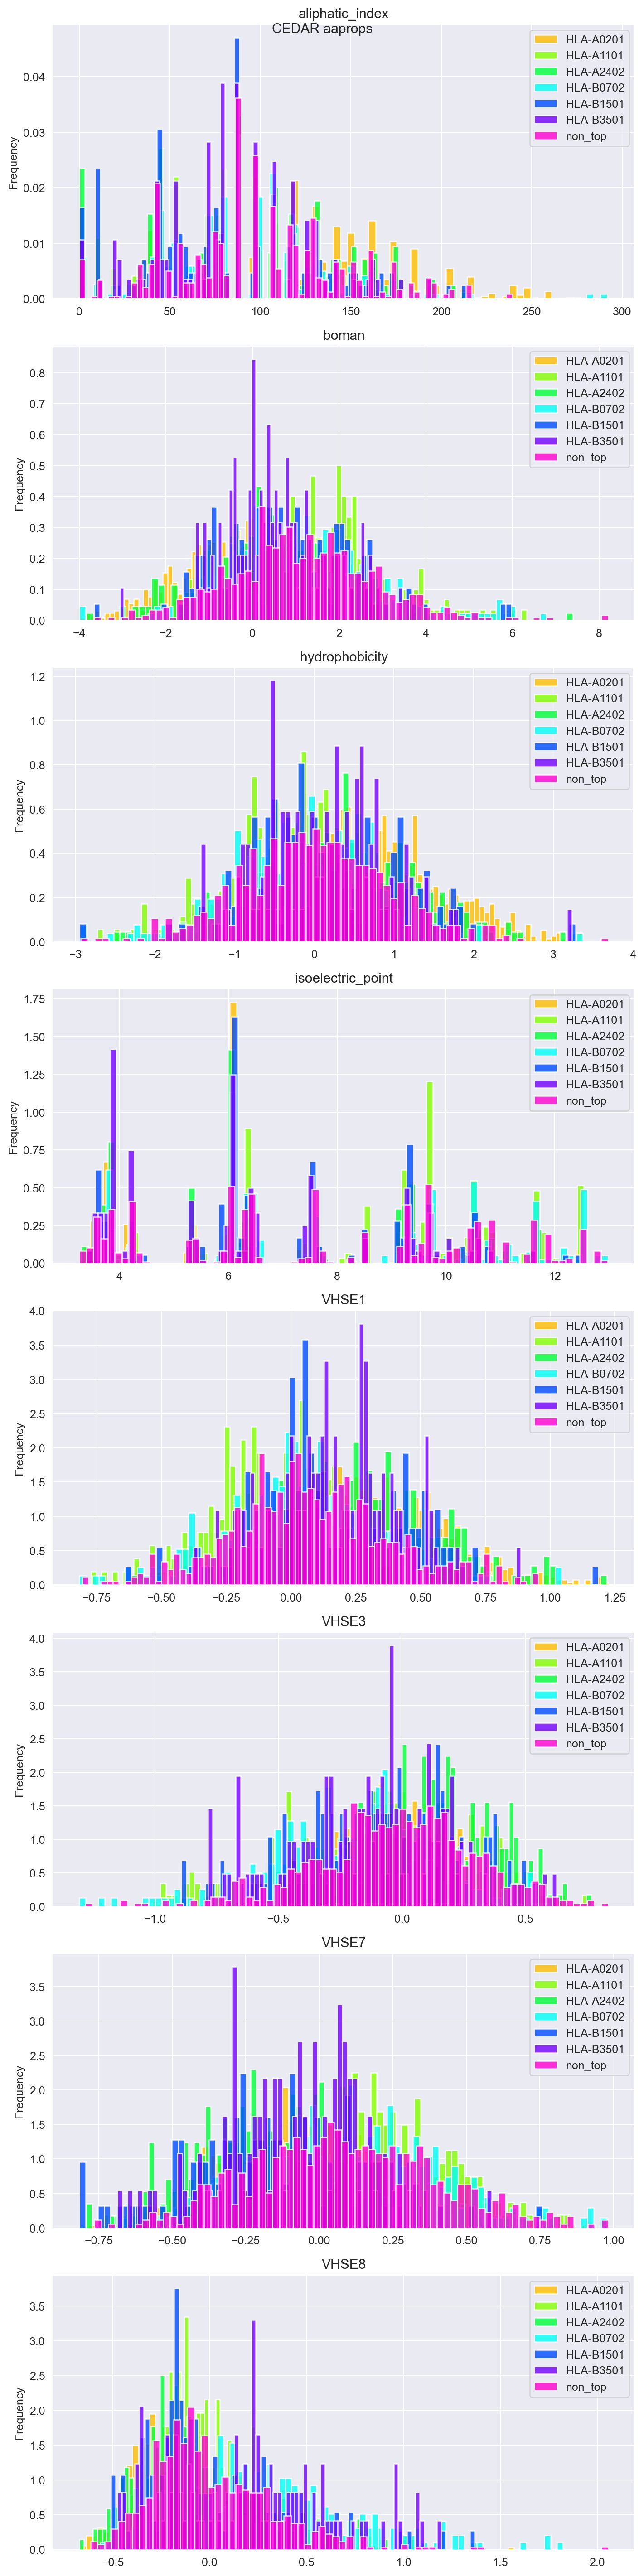

In [71]:
sns.set_palette('hsv',n_colors = 7)
f,a = plt.subplots(len(aa_cols), 1, figsize=(8, len(aa_cols)*4))
for col, axis in zip(aa_cols, a.ravel()):
    cedar_tmp.groupby('HLA')[col].plot(kind='hist', alpha=0.8, density=True, bins=75, ax= axis, title=col)
    axis.legend()
f.suptitle('CEDAR aaprops')
f.tight_layout()

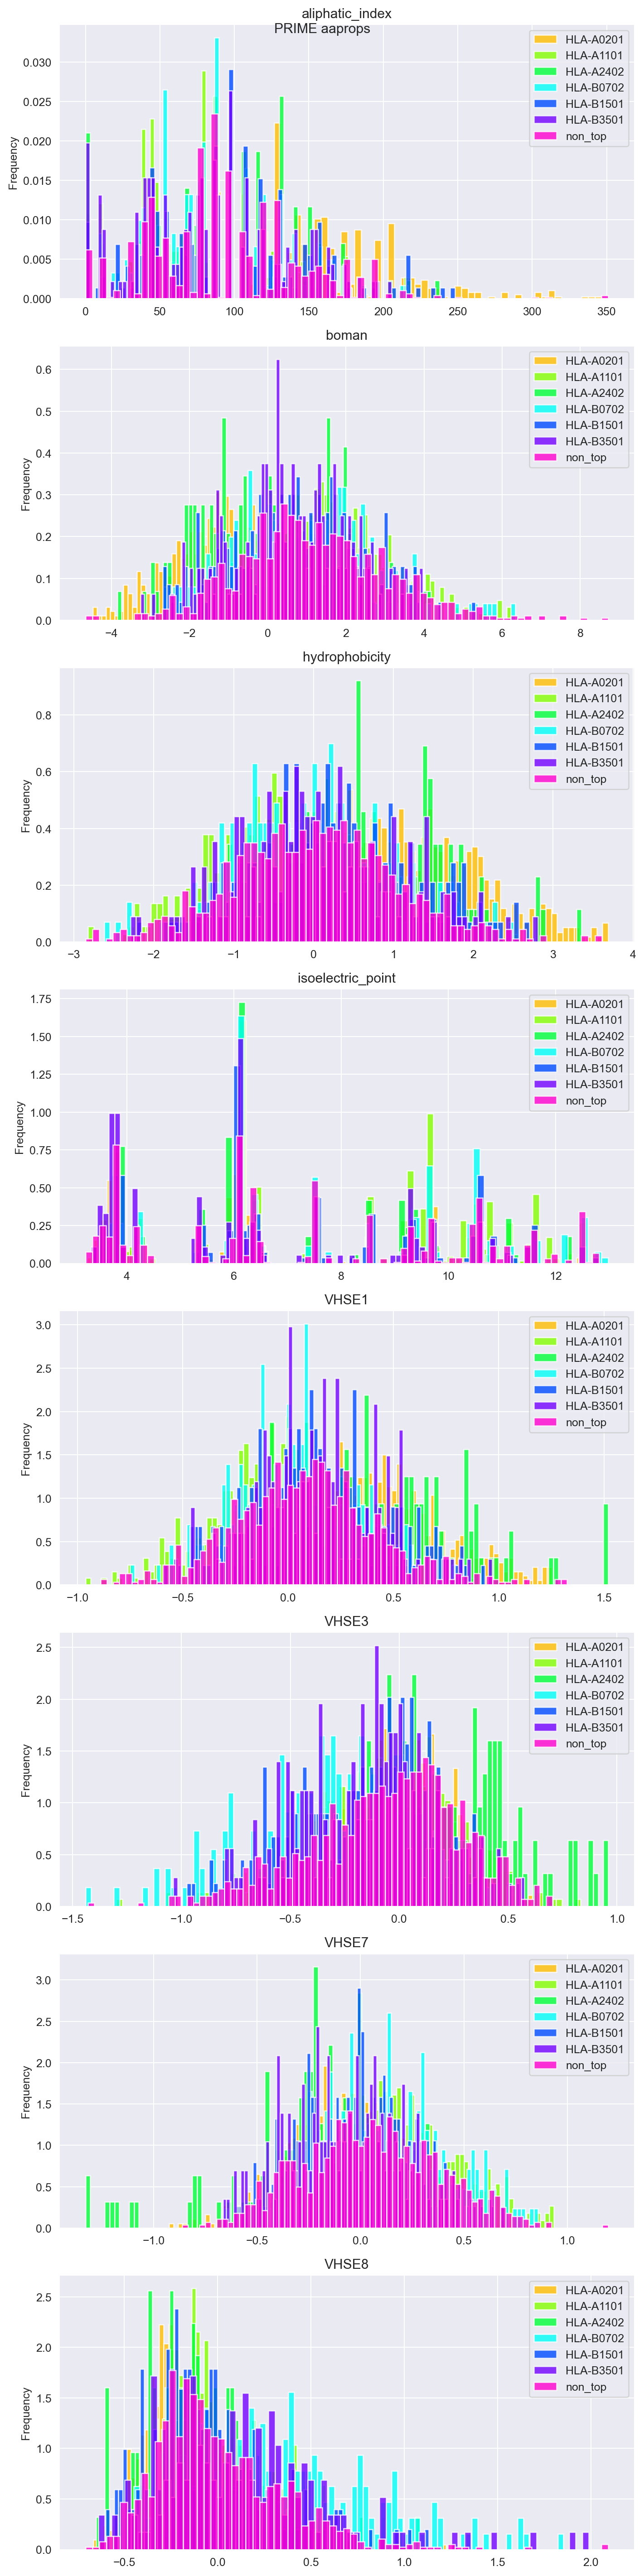

In [70]:
sns.set_palette('hsv',n_colors = 7)
f,a = plt.subplots(len(aa_cols), 1, figsize=(8, len(aa_cols)*4))
for col, axis in zip(aa_cols, a.ravel()):
    prime_tmp.groupby('HLA')[col].plot(kind='hist', alpha=0.8, density=True, bins=75, ax= axis, title=col)
    axis.legend()
f.suptitle('PRIME aaprops')
f.tight_layout()

# Get re-add top HLAs to the rest and check when it breaks 

using only EL rank, Peptide, onehot

In [211]:
from itertools import combinations
from src.utils import flatten_product

outlist = [set(item) for L in range(1, len(top_hlas)+1) for item in combinations(stuff, L)]
for add_back in outlist:
    df = cedar_related.query('HLA not in @top_hlas or HLA in @add_back')
    print(len(df), add_back, len(df.HLA.unique()), df.HLA.unique())
    # Then here can do stratified kfold randomsplit, and re-evaluate ; 
    # SAVE VALID PREDS (do eval on training df)
    # also eval on other datasets?
    

1922 {'HLA-A0201'} 58 ['HLA-A0201' 'HLA-C1203' 'HLA-A0206' 'HLA-B0801' 'HLA-B4002' 'HLA-B4403'
 'HLA-B4408' 'HLA-B4402' 'HLA-B4001' 'HLA-A6801' 'HLA-A0301' 'HLA-A1102'
 'HLA-A0202' 'HLA-B2705' 'HLA-C0702' 'HLA-B5701' 'HLA-A3001' 'HLA-A6802'
 'HLA-A0205' 'HLA-A0203' 'HLA-A0101' 'HLA-C1403' 'HLA-B5101' 'HLA-A2501'
 'HLA-B1801' 'HLA-C0602' 'HLA-C0102' 'HLA-A2601' 'HLA-A3301' 'HLA-B3801'
 'HLA-A3101' 'HLA-A2902' 'HLA-C0303' 'HLA-C0501' 'HLA-A0224' 'HLA-B5401'
 'HLA-B3901' 'HLA-C0304' 'HLA-B5601' 'HLA-C0802' 'HLA-A0211' 'HLA-C1502'
 'HLA-B3701' 'HLA-A0210' 'HLA-B4102' 'HLA-C1202' 'HLA-C0401' 'HLA-B1302'
 'HLA-C0701' 'HLA-A3002' 'HLA-B3503' 'HLA-B5201' 'HLA-B3906' 'HLA-B4901'
 'HLA-A6901' 'HLA-C1402' 'HLA-A0302' 'HLA-B3704']
1006 {'HLA-A1101'} 58 ['HLA-A1101' 'HLA-C1203' 'HLA-A0206' 'HLA-B0801' 'HLA-B4002' 'HLA-B4403'
 'HLA-B4408' 'HLA-B4402' 'HLA-B4001' 'HLA-A6801' 'HLA-A0301' 'HLA-A1102'
 'HLA-A0202' 'HLA-B2705' 'HLA-C0702' 'HLA-B5701' 'HLA-A3001' 'HLA-A6802'
 'HLA-A0205' 'HLA-A0203' 'HLA-

In [143]:
len(outlist)

63

In [142]:
[x for x in ibel.HLA.unique() if x in top_hlas]

['HLA-A1101', 'HLA-B0702', 'HLA-A0201']

In [212]:
len(cedar_related.query('HLA not in @top_hlas').HLA.unique())

57

## LOAD RESULTS

In [242]:
RDIR = '../output/221229_cedar_outputs/'
df_addback_reboot = pd.read_csv(f'{RDIR}221229_HLA_addback_rebootstrap_total_df.csv')
df_addback_retrain = pd.read_csv(f'{RDIR}221229_HLA_addback_retrain_total_df.csv')

## Get baseline for only "non top" for all 7 weightings

In [222]:
from src.bootstrap import bootstrap_eval
def final_bootstrap_wrapper(preds_df, filename, hla,
                            ic_name, trainset, evalset,
                            n_rounds=10000, n_jobs=36):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['hla'] = hla
    bootstrapped_df['evalset'] = evalset.upper()
    bootstrapped_df['trainset'] = trainset.upper()
    # bootstrapped_df['key'] = filename.split('_')[-1]
    bootstrapped_df['key'] = 'only_rank'
    # bootstrapped_df.to_csv(
        # f'{args["outdir"]}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        # index=False)
    # pkl_dump(mean_rocs,
             # f'{args["outdir"]}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df


### Retrain

#### Retrain hobohmfold

In [274]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                           add_aaprop=False, remove_pep=False, standardize=True,
                           target_col='agg_label', seq_col='Peptide', rank_col='EL_rank_mut', hla_col='HLA',
                           mask_aa=False)
top_hlas = ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']

cedar_dataset = cedar_related.query('HLA not in @top_hlas')
prime_dataset = prime_related.query('HLA not in @top_hlas')


trainname = 'CEDAR_REST'
hla = 'baseline-rest'

df_addback_retrain_rest_hobohmfold = pd.DataFrame()
for train_dataset, trainname in zip([cedar_dataset, prime_dataset], ['CEDAR', 'PRIME']):
    
    for invert in [True, False]:
        for ic_name, ics_dict in tqdm(
                zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                desc='Weighting', leave=False, position=2):
            start = dt.now()
             # Set args
            encoding_kwargs['invert'] = invert
            encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
            # Load params
            if invert:
                if ic_name == 'None':
                    continue
                else:
                    ic_name = 'Inverted ' + ic_name

            filename = f'{trainname}_onehot_{"-".join(ic_name.split(" "))}_{hla.replace(",","x")}_onlyrank'
            # Using the same model and hyperparameters
            # model = RandomForestClassifier(n_estimators=100, max_depth=5, ccp_alpha=5e-7)

            model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                           max_depth=8, ccp_alpha=9.945e-6)                    # Training model and getting feature importances
            print('Training')
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                        ics_dict=ics_dict,
                                                                        encoding_kwargs=encoding_kwargs,
                                                                        n_jobs=10)
            # train dataset = cedar dataset
            _, cedar_preds_df = evaluate_trained_models_sklearn(train_dataset,
                                                                trained_models,
                                                                ics_dict, train_dataset,
                                                                encoding_kwargs,
                                                                concatenated=True,
                                                                only_concat=True)

            cedar_bootstrapped_df = final_bootstrap_wrapper(cedar_preds_df, filename, hla, ic_name,
                                                            trainset=trainname,
                                                            evalset='CEDAR_REST', n_rounds=10000,
                                                            n_jobs=8)
            df_addback_retrain_rest_hobohmfold = df_addback_retrain_rest_hobohmfold.append(cedar_bootstrapped_df)

            # EVAL AND BOOTSTRAPPING ON PRIME
            _, prime_preds_df = evaluate_trained_models_sklearn(prime_dataset,
                                                                trained_models,
                                                                ics_dict, train_dataset,
                                                                encoding_kwargs,
                                                                concatenated=False,
                                                                only_concat=False)

            # Bootstrapping (PRIME)
            prime_bootstrapped_df = final_bootstrap_wrapper(prime_preds_df, filename, hla, ic_name,
                                                            trainset=trainname,evalset='PRIME_REST', n_rounds=10000,
                                                            n_jobs=8)
            df_addback_retrain_rest_hobohmfold = df_addback_retrain_rest_hobohmfold.append(prime_bootstrapped_df)
            end = dt.now()
            elapsed=  divmod((end-start).seconds, 60)
            print(f'SINGLE RUN ELAPSED : {elapsed[0]} minutes, {elapsed[1]} seconds')


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 22 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 21 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 19 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 18 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 22 seconds


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 18 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 19 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 23 seconds


#### Retrain randomfold

In [275]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                           add_aaprop=False, remove_pep=False, standardize=True,
                           target_col='agg_label', seq_col='Peptide', rank_col='EL_rank_mut', hla_col='HLA',
                           mask_aa=False)
top_hlas = ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']

cedar_dataset = cedar_related.query('HLA not in @top_hlas')
prime_dataset = prime_related.query('HLA not in @top_hlas')


trainname = 'CEDAR_REST'
hla = 'baseline-rest'

df_addback_retrain_rest_randomfold = pd.DataFrame()
for train_dataset, trainname in zip([cedar_dataset, prime_dataset], ['CEDAR', 'PRIME']):
    skf = StratifiedKFold(n_splits=10, random_state=13, shuffle=True)
    for i, (train_idx, test_idx) in enumerate(skf.split(X=train_dataset['Peptide'].values,
                                                        y=train_dataset['agg_label'].values,
                                                        groups=train_dataset['agg_label'].values)):
        train_dataset.iloc[test_idx, list(train_dataset.columns).index('fold')] = i
    for invert in [True, False]:
        for ic_name, ics_dict in tqdm(
                zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                desc='Weighting', leave=False, position=2):
            start = dt.now()
             # Set args
            encoding_kwargs['invert'] = invert
            encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
            # Load params
            if invert:
                if ic_name == 'None':
                    continue
                else:
                    ic_name = 'Inverted ' + ic_name

            filename = f'{trainname}_onehot_{"-".join(ic_name.split(" "))}_{hla.replace(",","x")}_onlyrank'
            # Using the same model and hyperparameters
            # model = RandomForestClassifier(n_estimators=100, max_depth=5, ccp_alpha=5e-7)

            model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                           max_depth=8, ccp_alpha=9.945e-6)                    # Training model and getting feature importances
            print('Training')
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                        ics_dict=ics_dict,
                                                                        encoding_kwargs=encoding_kwargs,
                                                                        n_jobs=10)
            # train dataset = cedar dataset
            _, cedar_preds_df = evaluate_trained_models_sklearn(train_dataset,
                                                                trained_models,
                                                                ics_dict, train_dataset,
                                                                encoding_kwargs,
                                                                concatenated=True,
                                                                only_concat=True)

            cedar_bootstrapped_df = final_bootstrap_wrapper(cedar_preds_df, filename, hla, ic_name,
                                                            trainset=trainname,
                                                            evalset='CEDAR_REST', n_rounds=10000,
                                                            n_jobs=8)
            df_addback_retrain_rest_randomfold = df_addback_retrain_rest_randomfold.append(cedar_bootstrapped_df)

            # EVAL AND BOOTSTRAPPING ON PRIME
            _, prime_preds_df = evaluate_trained_models_sklearn(prime_dataset,
                                                                trained_models,
                                                                ics_dict, train_dataset,
                                                                encoding_kwargs,
                                                                concatenated=False,
                                                                only_concat=False)

            # Bootstrapping (PRIME)
            prime_bootstrapped_df = final_bootstrap_wrapper(prime_preds_df, filename, hla, ic_name,
                                                            trainset=trainname,evalset='PRIME_REST', n_rounds=10000,
                                                            n_jobs=8)
            df_addback_retrain_rest_randomfold = df_addback_retrain_rest_randomfold.append(prime_bootstrapped_df)
            end = dt.now()
            elapsed=  divmod((end-start).seconds, 60)
            print(f'SINGLE RUN ELAPSED : {elapsed[0]} minutes, {elapsed[1]} seconds')


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 22 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 21 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 19 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 21 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 19 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 21 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 21 seconds


Weighting: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 19 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 18 seconds
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
SINGLE RUN ELAPSED : 0 minutes, 20 seconds


### Reboot

In [224]:
PREDSDIR = '../output/221122_mutscore_cedar_fixed/230102_copy/'
for invert in [True, False]:
    for ic_name, ics_dict in tqdm(
            zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
            desc='Weighting', leave=False, position=2):
        # Set args
        encoding_kwargs['invert'] = invert
        encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
        # Load params
        if invert:
            if ic_name == 'None':
                continue
            else:
                ic_name = 'Inverted ' + ic_name
        # creating filename
        start = dt.now()
        filename = f'trainCedar_onehot_{"-".join(ic_name.split(" "))}_{hla.replace(",","x")}_onlyrank'
        pred_filename = f'_preds_onehot_{"-".join(ic_name.split(" "))}_Peptide_EL_rank_mut_only_rank'
        # Using the same model and hyperparameters
        # model = RandomForestClassifier(n_estimators=100, max_depth=5, ccp_alpha=5e-7)
        cedar_preds_df = pd.read_csv(f'{PREDSDIR}cedar{pred_filename}.csv')\
                           .query('HLA not in @top_hlas or HLA in @add_back')
        prime_preds_df = pd.read_csv(f'{PREDSDIR}prime{pred_filename}.csv')\
                           .query('HLA not in @top_hlas or HLA in @add_back')

        # Re-Bootstrapping (CEDAR)
        cedar_bootstrapped_df = final_bootstrap_wrapper(cedar_preds_df, filename, hla, ic_name,
                                                        trainset=trainname,
                                                        evalset='CEDAR_REST', n_rounds=10000,
                                                        n_jobs=8)
        df_addback_reboot = df_addback_reboot.append(cedar_bootstrapped_df)

        # Re-Bootstrapping (PRIME)
        prime_bootstrapped_df = final_bootstrap_wrapper(prime_preds_df, filename, hla, ic_name,
                                                        trainset=trainname,
                                                        evalset='PRIME_REST', n_rounds=10000,
                                                        n_jobs=8)
        df_addback_reboot = df_addback_reboot.append(prime_bootstrapped_df)
        end = dt.now()
        elapsed = divmod((end-start).seconds,60)
        print(f'elapsed : {elapsed[0]} minutes, {elapsed[1]} seconds')

Weighting: 0it [00:00, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
elapsed : 0 minutes, 25 seconds
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
elapsed : 0 minutes, 18 seconds
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
elapsed : 0 minutes, 17 seconds


Weighting: 0it [00:00, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
elapsed : 0 minutes, 18 seconds
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
elapsed : 0 minutes, 18 seconds
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
elapsed : 0 minutes, 17 seconds
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
elapsed : 0 minutes, 17 seconds


# Results from various experiments

In [144]:
RDIR = '../output/221229_cedar_outputs/'
df_randomfold = pd.read_csv(f'{RDIR}221123_mutscore_cedar_randomfold_total_df.csv')
df_a11_rest = pd.read_csv(f'{RDIR}221223_cedar_a11rest_vs_top_total_df.csv')
df_noa11 = pd.read_csv(f'{RDIR}221323_mutscores_cedar_noa11_total_df.csv')

## addback rebootstrapped

In [392]:
sns.catplot(kind='bar', data=df_addback_reboot_cedar, y = 'mean_auc', hue='weight',
            col_wrap=3, x = 'hla', nrows=)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 2700x0 with 0 Axes>

In [377]:
df_addback_reboot_cedar = df_addback_reboot.query('evalset=="CEDAR_REST"').drop(columns=['evalset','trainset']).groupby(['hla', 'weight']).agg(mean_auc = ('auc','mean')).reset_index()
df_addback_reboot_prime = df_addback_reboot.query('evalset=="PRIME_REST"').drop(columns=['evalset','trainset']).groupby(['hla', 'weight']).agg(mean_auc = ('auc','mean')).reset_index()
# .groupby(['evalset','hla','weight']).agg(mean_auc=('auc', 'mean')).reset_index('weight')

In [399]:
sns.catplot(data=df_addback_reboot.query('evalset=="CEDAR_REST"'), x='weight', col='hla', y='auc',
            kind = 'bar', col_wrap=5)

In [407]:
df_addback_reboot_cedar.merge((df_addback_reboot_cedar.groupby(['hla'])[['mean_auc']].transform(max)-df_addback_reboot_cedar[['mean_auc']]).rename(columns={'mean_auc':'diff_from_max'}),
                              left_index=True, right_index=True)

hla            weight  mean_auc  \
0                                  A0201       Inverted KL  0.687648   
1                                  A0201     Inverted Mask  0.678152   
2                                  A0201  Inverted Shannon  0.685812   
3                                  A0201                KL  0.681961   
4                                  A0201              Mask  0.673234   
5                                  A0201              None  0.683082   
6                                  A0201           Shannon  0.682114   
7          A0201,A2402,B3501,A1101,B1501       Inverted KL  0.710441   
8          A0201,A2402,B3501,A1101,B1501     Inverted Mask  0.691240   
9          A0201,A2402,B3501,A1101,B1501  Inverted Shannon  0.709088   
10         A0201,A2402,B3501,A1101,B1501                KL  0.686890   
11         A0201,A2402,B3501,A1101,B1501              Mask  0.685937   
12         A0201,A2402,B3501,A1101,B1501              None  0.692451   
13         A0201,A2402,B3501,A1101,B1501           Shannon  0.686791   
14                                 A1101       Inverted KL  0.670712   
15                                 A1101     Inverted Mask  0.635642   
16                                 A1101  Inverted Shannon  0.667710   
17                                 A1101                KL  0.616558   
18                                 A1101              Mask  0.602009   
19                                 A1101              None  0.627114   
20                                 A1101           Shannon  0.616949   
21                           A1101,A0201       Inverted KL  0.704473   
22                           A1101,A0201     Inverted Mask  0.690452   
23                           A1101,A0201  Inverted Shannon  0.702880   
24                           A1101,A0201                KL  0.688646   
25                           A1101,A0201              Mask  0.678382   
26                           A1101,A0201              None  0.692525   
27                           A1101,A0201           Shannon  0.688704   
28                           A1101,B1501       Inverted KL  0.682012   
29                           A1101,B1501     Inverted Mask  0.648795   
30                           A1101,B1501  Inverted Shannon  0.679147   
31                           A1101,B1501                KL  0.633881   
32                           A1101,B1501              Mask  0.622793   
33                           A1101,B1501              None  0.640839   
34                           A1101,B1501           Shannon  0.634146   
35                                 A2402       Inverted KL  0.643042   
36                                 A2402     Inverted Mask  0.600387   
37                                 A2402  Inverted Shannon  0.639763   
38                                 A2402                KL  0.587439   
39                                 A2402              Mask  0.592303   
40                                 A2402              None  0.596280   
41                                 A2402           Shannon  0.587618   
42                           A2402,A0201       Inverted KL  0.693874   
43                           A2402,A0201     Inverted Mask  0.674273   
44                           A2402,A0201  Inverted Shannon  0.692215   
45                           A2402,A0201                KL  0.673100   
46                           A2402,A0201              Mask  0.671772   
47                           A2402,A0201              None  0.677230   
48                           A2402,A0201           Shannon  0.673010   
49                           A2402,A1101       Inverted KL  0.672832   
50                           A2402,A1101     Inverted Mask  0.628977   
51                           A2402,A1101  Inverted Shannon  0.670271   
52                           A2402,A1101                KL  0.612563   
53                           A2402,A1101              Mask  0.613284   
54                           A2402,A1101              None  0.622455   
55   

In [402]:
100*(df_addback_reboot_cedar.groupby(['hla'])[['mean_auc']].transform(max)-df_addback_reboot_cedar[['mean_auc']])

mean_auc
0    0.000000
1    0.949570
2    0.183597
3    0.568709
4    1.441431
5    0.456562
6    0.553415
7    0.000000
8    1.920046
9    0.135282
10   2.355102
11   2.450332
12   1.798925
13   2.365017
14   0.000000
15   3.506920
16   0.300153
17   5.415310
18   6.870273
19   4.359760
20   5.376296
21   0.000000
22   1.402051
23   0.159316
24   1.582700
25   2.609100
26   1.194823
27   1.576854
28   0.000000
29   3.321719
30   0.286463
31   4.813109
32   5.921947
33   4.117305
34   4.786597
35   0.000000
36   4.265560
37   0.327894
38   5.560316
39   5.073973
40   4.676203
41   5.542406
42   0.000000
43   1.960184
44   0.165937
45   2.077401
46   2.210217
47   1.664415
48   2.086417
49   0.000000
50   4.385460
51   0.256097
52   6.026835
53   5.954740
54   5.037639
55   6.024996
56   0.000000
57   2.220695
58   0.148365
59   2.720075
60   3.045507
61   2.128873
62   2.733549
63   0.000000
64   3.994392
65   0.252328
66   5.289743
67   5.070626
68   4.593235
69   5.292956
70   0.000000
71   3.873843
72   0.304927
73   4.828279
74   4.274857
75   4.273014
76   4.819376
77   0.000000
78   3.658678
79   0.270818
80   4.970917
81   4.152348
82   3.918096
83   4.963918
84   0.000000
85   1.763777
86   0.147220
87   1.942842
88   1.926187
89   1.438099
90   1.953035
91   0.000000
92   3.774526
93   0.216188
94   5.351687
95   4.932513
96   4.252359
97   5.354703
98   0.000000
99   2.021489
100  0.134426
101  2.549217
102  2.719585
103  1.886671
104  2.562457
105  0.000000
106  3.421895
107  0.218269
108  4.653412
109  4.126369
110  3.847720
111  4.659887
112  0.000000
113  3.297025
114  0.262128
115  4.252651
116  3.388808
117  3.532418
118  4.250871
119  0.000000
120  2.493364
121  0.273607
122  3.485830
123  5.006973
124  3.099978
125  3.418068
126  0.000000
127  0.973583
128  0.151584
129  0.784623
130  1.860580
131  0.644589
132  0.764682
133  0.000000
134  0.996355
135  0.149997
136  0.778909
137  1.715993
138  0.711926
139  0.754705
140  0.000000
141  2.933584
142  0.209891
143  4.386843
144  5.886546
145  3.800715
146  4.345393
147  0.000000
148  1.374872
149  0.132742
150  1.631059
151  2.774265
152  1.279956
153  1.619541
154  0.000000
155  1.326506
156  0.134705
157  1.509875
158  2.531011
159  1.248383
160  1.493055
161  0.000000
162  2.696095
163  0.215985
164  3.805464
165  4.967397
166  3.449475
167  3.764978
168  0.000000
169  3.405231
170  0.230848
171  4.316363
172  4.388040
173  3.856531
174  4.285777
175  0.000000
176  1.804779
177  0.140220
178  1.959551
179  2.350449
180  1.594094
181  1.959468
182  0.000000
183  1.729085
184  0.142185
185  1.830799
186  2.130436
187  1.553070
188  1.824956
189  0.000000
190  3.560991
191  0.190908
192  4.790525
193  5.000474
194  4.196903
195  4.770668
196  0.000000
197  2.044772
198  0.127724
199  2.524670
200  3.029321
201  2.011826
202  2.527344
203  0.000000
204  3.246837
205  0.199972
206  4.197703
207  4.252729
208  3.808023
209  4.178042
210  0.000000
211  3.058086
212  0.231745
213  3.688181
214  3.581799
215  3.448994
216  3.660667
217  0.000000
218  2.827857
219  0.194562
220  3.736886
221  3.447859
222  3.124873
223  3.708350
224  0.000000
225  1.615028
226  0.126467
227  1.826456
228  2.055908
229  1.377047
230  1.825182
231  0.000000
232  2.992660
233  0.162003
234  4.165322
235  4.065725
236  3.470558
237  4.145936
238  0.000000
239  1.811916
240  0.113151
241  2.302025
242  2.645187
243  1.731617
244  2.304330
245  0.000000
246  2.690523
247  0.173775
248  3.579412
249  3.339865
250  3.089302
251  3.560413
252  0.000000
253  2.510644
254  0.198191
255  3.132100
256  2.700451
257  2.738789
258  3.105896
259  0.000000
260  2.313367
261  0.264774
262  2.995066
263  4.146771
264  2.836554
265  2.934159
266  0.000000
267  1.976653
268  0.223836
269  3.020915
270  4.049978
271  2.448036
272  2.961531
273  0.000000
274  0.839636
275  0.132209
276  0.740014
277  1.619486
278  0.498192
279  0.722503
280  0.000000
281  0.828999
282  0.134449
283  0.697926
284  1.463210
2

In [378]:
idx_reboot_cedar = df_addback_reboot_cedar.groupby(['hla'])['mean_auc'].transform(max) == df_addback_reboot_cedar['mean_auc']
idx_reboot_prime = df_addback_reboot_prime.groupby(['hla'])['mean_auc'].transform(max) == df_addback_reboot_prime['mean_auc']

display(df_addback_reboot_cedar.loc[idx_reboot_cedar].groupby('weight').count()), 
display(df_addback_reboot_prime.loc[idx_reboot_prime].groupby('weight').count())

hla  mean_auc
weight                    
Inverted KL   63        63

hla  mean_auc
weight                      
Inverted Mask    1         1
Mask            62        62

In [379]:
df_addback_reboot_prime.loc[idx_reboot_prime].query('weight!="Mask"')

hla         weight  mean_auc
15  A1101  Inverted Mask  0.726692

In [239]:
df_addback_reboot_cedar.query('hla=="baseline-rest"')

hla            weight  mean_auc
441  baseline-rest       Inverted KL  0.720798
442  baseline-rest     Inverted Mask  0.703641
443  baseline-rest  Inverted Shannon  0.719614
444  baseline-rest                KL  0.699516
445  baseline-rest              Mask  0.696834
446  baseline-rest              None  0.704340
447  baseline-rest           Shannon  0.699542

In [364]:
pd.set_option('display.max_rows',441)
df_addback_reboot_cedar.loc[idx_reboot_cedar].groupby('weight').count()

hla  mean_auc
weight                    
Inverted KL   64        64

In [366]:
df_addback_reboot_prime

hla            weight  mean_auc
0            A0201       Inverted KL  0.651981
1            A0201     Inverted Mask  0.669774
2            A0201  Inverted Shannon  0.652220
3            A0201                KL  0.658167
4            A0201              Mask  0.677741
..             ...               ...       ...
443  baseline-rest  Inverted Shannon  0.652969
444  baseline-rest                KL  0.684138
445  baseline-rest              Mask  0.708976
446  baseline-rest              None  0.686805
447  baseline-rest           Shannon  0.684898

[448 rows x 3 columns]

In [368]:
df_addback_reboot_prime.loc[idx_reboot_prime]

hla         weight  mean_auc
4                                  A0201           Mask  0.677741
11         A0201,A2402,B3501,A1101,B1501           Mask  0.700534
15                                 A1101  Inverted Mask  0.726692
25                           A1101,A0201           Mask  0.699364
32                           A1101,B1501           Mask  0.722942
39                                 A2402           Mask  0.688685
46                           A2402,A0201           Mask  0.672307
53                           A2402,A1101           Mask  0.716430
60                     A2402,A1101,A0201           Mask  0.694113
67                     A2402,A1101,B1501           Mask  0.715130
74                           A2402,B1501           Mask  0.692716
81                           A2402,B3501           Mask  0.699951
88                     A2402,B3501,A0201           Mask  0.681385
95                     A2402,B3501,A1101           Mask  0.722229
102              A2402,B3501,A1101,A0201           Mask  0.700016
109              A2402,B3501,A1101,B1501           Mask  0.721505
116                    A2402,B3501,B1501           Mask  0.703411
123                                B0702           Mask  0.718317
130                          B0702,A0201           Mask  0.691783
137                    B0702,A0201,B1501           Mask  0.693903
144                          B0702,A1101           Mask  0.736565
151                    B0702,A1101,A0201           Mask  0.708695
158              B0702,A1101,A0201,B1501           Mask  0.708710
165                    B0702,A1101,B1501           Mask  0.733197
172                          B0702,A2402           Mask  0.708082
179                    B0702,A2402,A0201           Mask  0.686173
186              B0702,A2402,A0201,B1501           Mask  0.689239
193                    B0702,A2402,A1101           Mask  0.727186
200              B0702,A2402,A1101,A0201           Mask  0.704425
207              B0702,A2402,A1101,B1501           Mask  0.725932
214                    B0702,A2402,B1501           Mask  0.708881
221                    B0702,A2402,B3501           Mask  0.716577
228              B0702,A2402,B3501,A0201           Mask  0.692856
235              B0702,A2402,B3501,A1101           Mask  0.731948
242        B0702,A2402,B3501,A1101,A0201           Mask  0.708252
249        B0702,A2402,B3501,A1101,B1501           Mask  0.730508
256              B0702,A2402,B3501,B1501           Mask  0.717250
263                          B0702,B1501           Mask  0.718201
270                          B0702,B3501           Mask  0.726171
277                    B0702,B3501,A0201           Mask  0.698578
284              B0702,B3501,A0201,B1501           Mask  0.700074
291                    B0702,B3501,A1101           Mask  0.740885
298              B0702,B3501,A1101,A0201           Mask  0.713509
305              B0702,B3501,A1101,B1501           Mask  0.737759
312                    B0702,B3501,B1501           Mask  0.725716
319                                B1501           Mask  0.701339
326                          B1501,A0201           Mask  0.681233
333                    B1501,A1101,A0201           Mask  0.700203
340                    B1501,A2402,A0201           Mask  0.677062
347              B1501,A2402,A1101,A0201           Mask  0.695701
354              B1501,A2402,B3501,A0201           Mask  0.684709
361        B1501,B0702,A2402,A1101,A0201           Mask  0.703990
368        B1501,B0702,A2402,B3501,A0201           Mask  0.695227
375  B1501,B0702,A2402,B3501,A1101,A0201           Mask  0.708976
382        B1501,B0702,B3501,A1101,A0201           Mask  0.713278
389                    B1501,B3501,A0201           Mask  0.689193
396              B1501,B3501,A1101,A0201           Mask  0.705146
403                                B3501           Mask  0.709484
410                          B3501,A0201           Mask  0.686014
417                          B3501,A1101           Mask  0.730274
424        

## addback retrained

In [369]:
df_addback_retrain_cedar = df_addback_retrain.query('evalset=="CEDAR_REST"').drop(columns=['evalset','trainset']).groupby(['hla', 'weight']).agg(mean_auc = ('auc','mean')).reset_index()
df_addback_retrain_prime = df_addback_retrain.query('evalset=="PRIME_REST"').drop(columns=['evalset','trainset']).groupby(['hla', 'weight']).agg(mean_auc = ('auc','mean')).reset_index()
# .groupby(['evalset','hla','weight']).agg(mean_auc=('auc', 'mean')).reset_index('weight')

In [370]:
idx_retrain_cedar = df_addback_retrain_cedar.groupby(['hla'])['mean_auc'].transform(max) == df_addback_retrain_cedar['mean_auc']
idx_retrain_prime = df_addback_retrain_prime.groupby(['hla'])['mean_auc'].transform(max) == df_addback_retrain_prime['mean_auc']

In [374]:
display(df_addback_retrain_cedar.loc[idx_retrain_cedar].groupby(['weight']).count())
display(df_addback_retrain_prime.loc[idx_retrain_prime].groupby(['weight']).count())

hla  mean_auc
weight                         
Inverted KL        41        41
Inverted Mask      14        14
Inverted Shannon    8         8
None                1         1

hla  mean_auc
weight                      
Inverted Mask    1         1
Mask            58        58
None             5         5

In [380]:
df_addback_retrain_cedar.loc[idx_retrain_cedar].query('weight=="None" or hla == "baseline-rest"')

hla         weight  mean_auc
222  B0702,B3501,A0201           None  0.743896
442      baseline-rest  Inverted Mask  0.658914

### Hobohm split retrain boxplot

In [349]:
def replace_weight(weight):
    if weight == 'None':
        return weight
    else:
        if 'Inverted' in weight:
            weight = weight.replace('Inverted', 'IC')
        else:
            weight = '(1-IC) ' + weight
            
        if 'KL' in weight:
            return weight.replace('KL', 'KL/Sh')
        elif 'Shannon' in weight:
            return weight.replace('Shannon', 'KL/Sh')
        elif weight == 'Mask':
            return 'IC ' + weight
        return weight

In [350]:
tmp_df.weight.unique()

array(['IC  Mask', 'IC  KL/Sh', '(1-IC) Mask', '(1-IC) KL/Sh', 'None'],
      dtype=object)

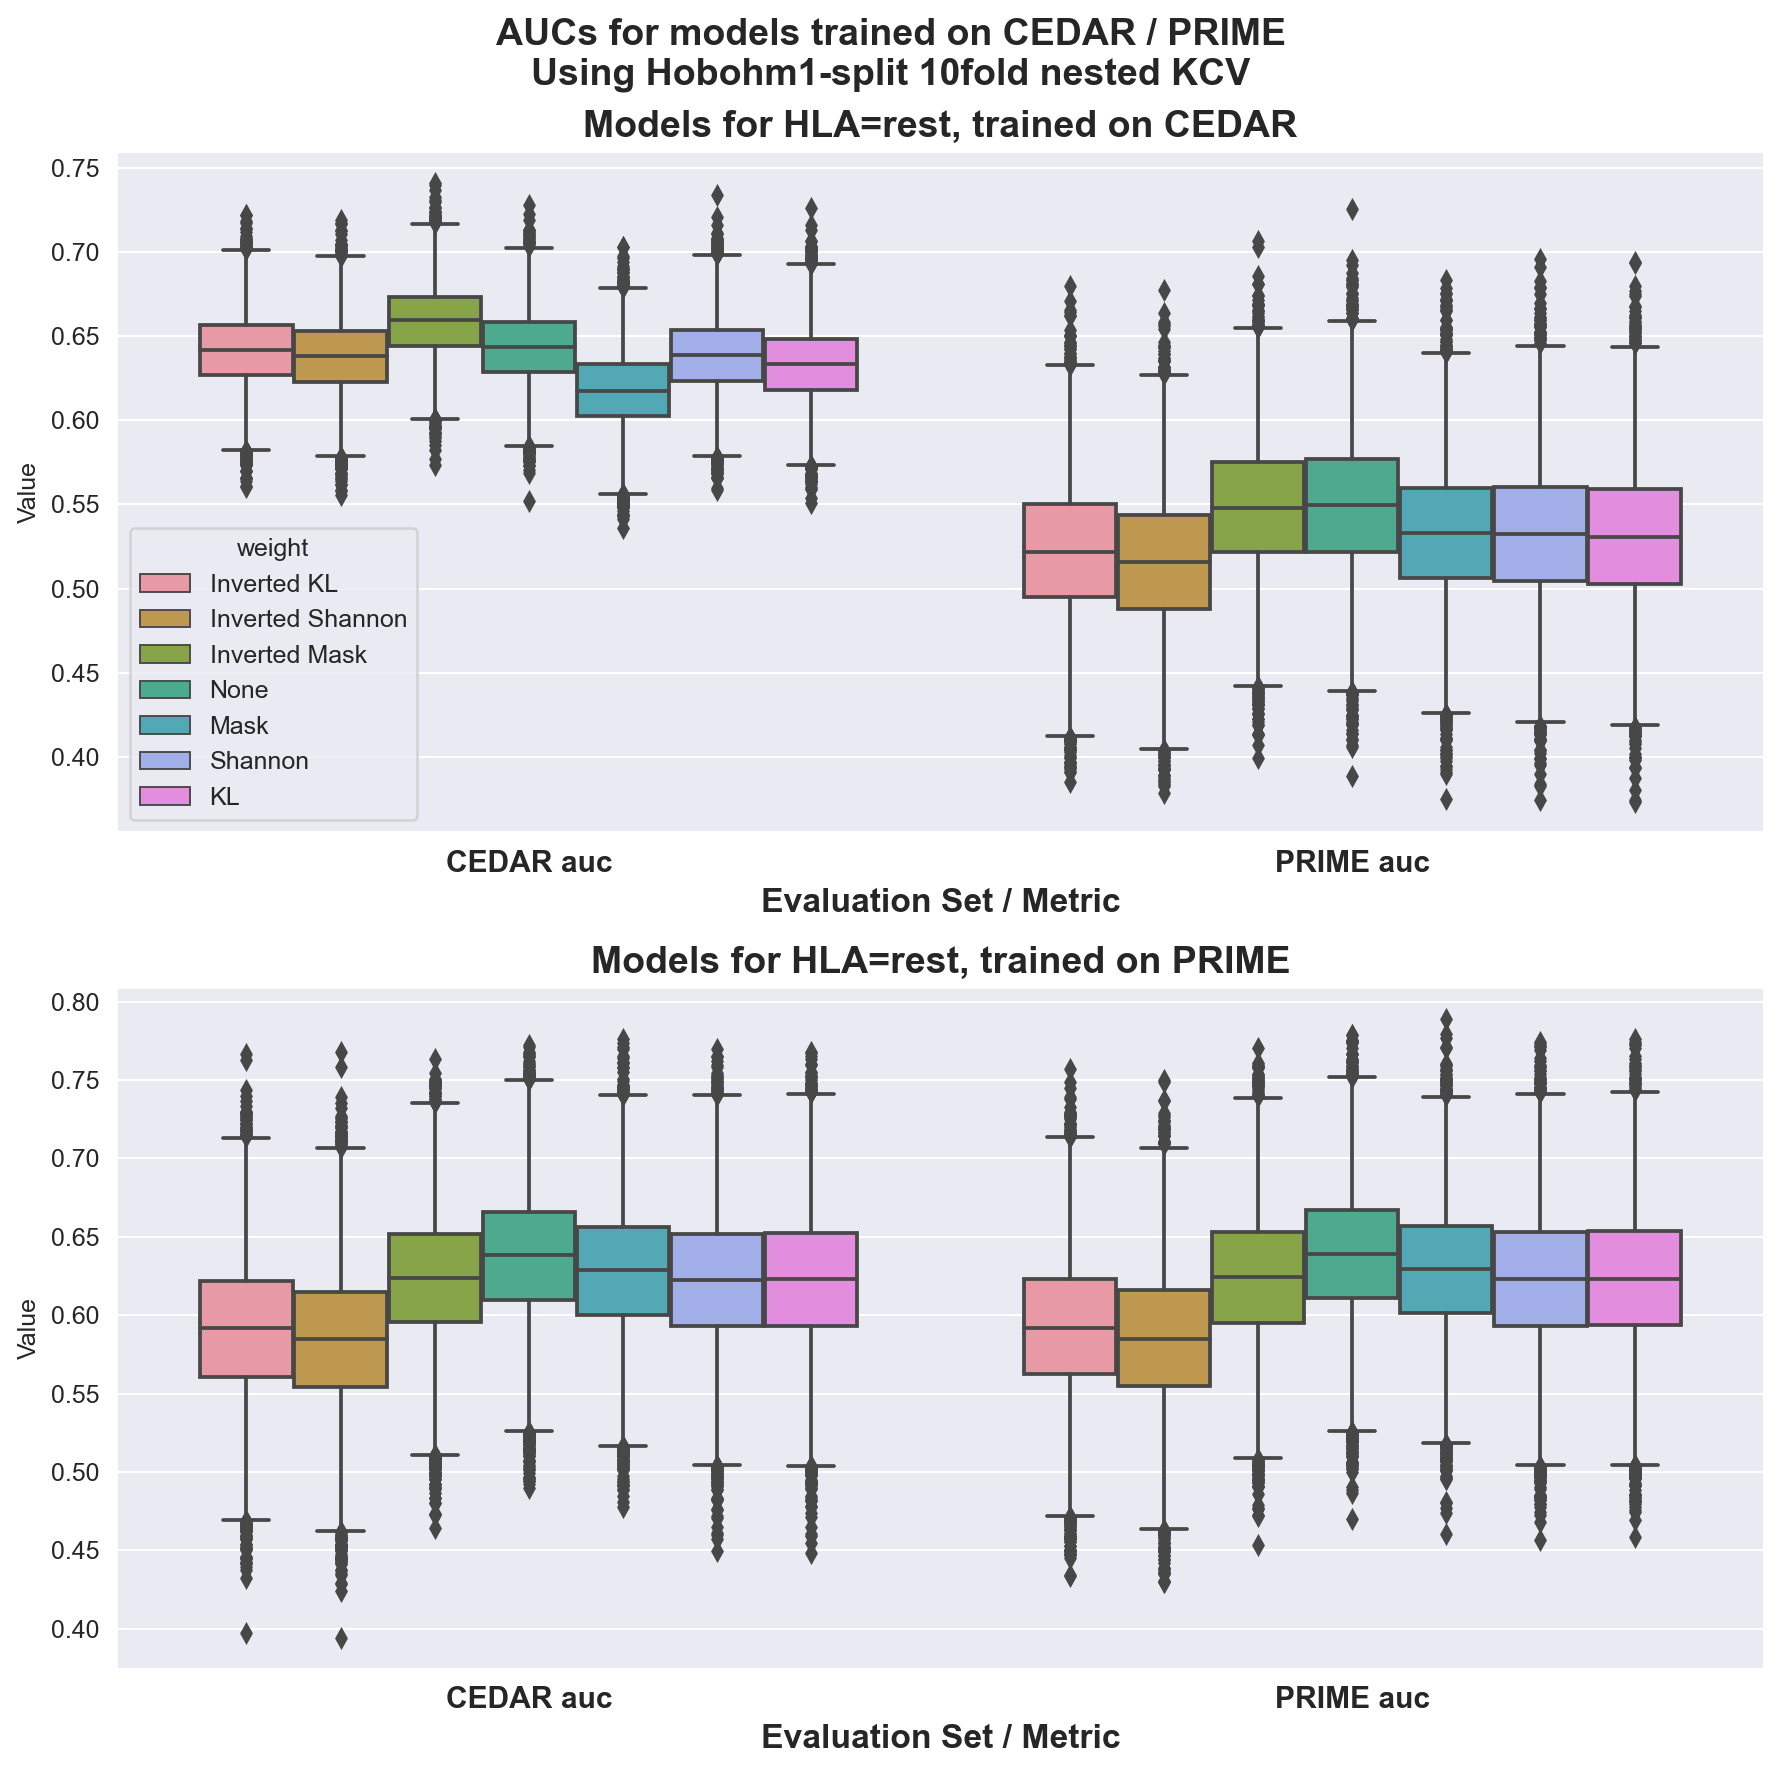

In [363]:
hla = 'rest'
sns.set_palette('hsv')
f,a = plt.subplots(2, 1, figsize=(10,10))
df_redo = df_addback_retrain_rest_hobohmfold.copy()
df_redo['trainset'] = df_redo['trainset'].str.replace('_REST','')
df_redo['evalset'] = df_redo['evalset'].str.replace('_REST','')

weight_order = ['Inverted KL', 'Inverted Shannon', 'Inverted Mask', 'None','Mask', 'Shannon', 'KL']

# weight_order = ['IC KL/Sh', 'IC Mask', 'None', '(1-IC) Mask', '(1-IC) KL/Sh']

for trainset, axis in zip(['CEDAR', 'PRIME'], a.ravel()):
    tmp_df = pd.melt(df_redo.query('hla == "baseline-rest" and trainset==@trainset').drop(columns = ['hla', 'trainset']),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc'])
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'Models for HLA={hla}, trained on {trainset}', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12))
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')
axis.legend([], frameon=False)
f.suptitle('AUCs for models trained on CEDAR / PRIME\nUsing Hobohm1-split 10fold nested KCV',
          fontweight='semibold', fontsize=15)
f.tight_layout()
f.savefig('../output/hla_analysis_fixed/boxplot_nontop_10-hobohmfolds.png', bbox_inches='tight',
          dpi=200)
# f.savefig(f'../output/hla_analysis_fixed/baseline-REST_models_boxplots_FixedQuery.png', bbox_inches = 'tight', dpi = 200)`
# df_addback_retrain.query('trainset=="CEDAR_REST" and evalset=="CEDAR_REST" and hla=="baseline-rest"')

### Random split retrain boxplot

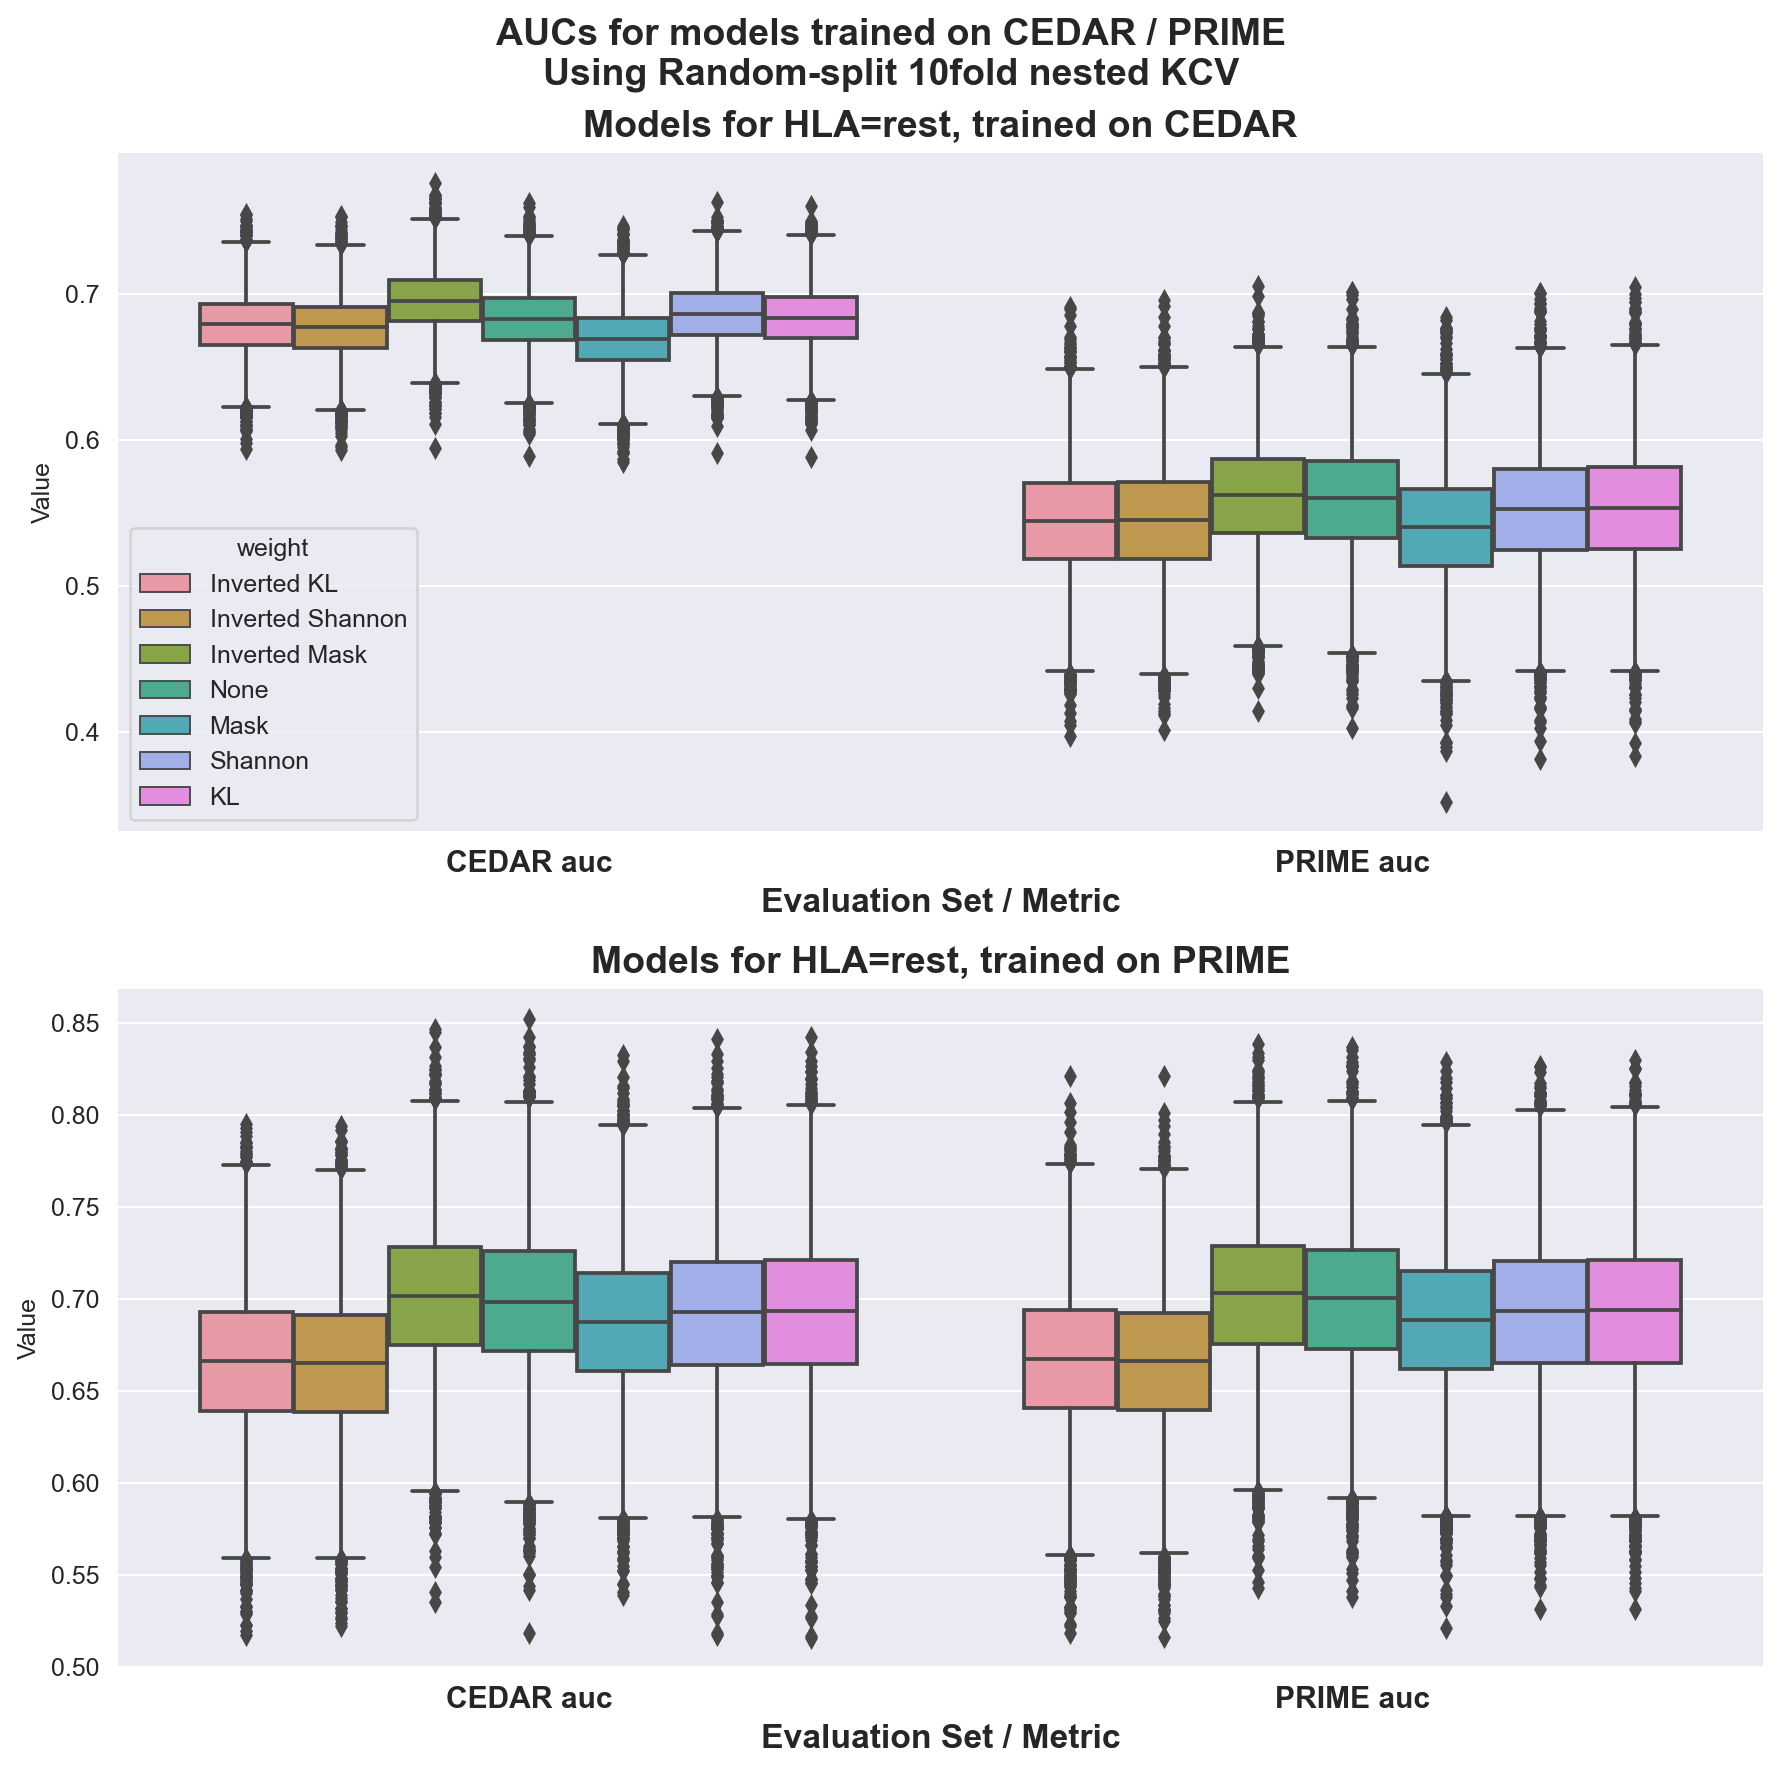

In [362]:
# RANDOMFOLD
hla = 'rest'
f,a = plt.subplots(2, 1, figsize=(10,10))
df_redo = df_addback_retrain_rest_randomfold.copy()
df_redo['trainset'] = df_redo['trainset'].str.replace('_REST','')
df_redo['evalset'] = df_redo['evalset'].str.replace('_REST','')
# weight_order = ['IC KL/Sh', 'IC Mask', 'None', '(1-IC) Mask', '(1-IC) KL/Sh']

weight_order = ['Inverted KL', 'Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon', 'KL']
for trainset, axis in zip(['CEDAR', 'PRIME'], a.ravel()):
    tmp_df = pd.melt(df_redo.query('hla == "baseline-rest" and trainset==@trainset').drop(columns = ['hla', 'trainset']),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc'])
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)

    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'Models for HLA={hla}, trained on {trainset}', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12))
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')

f.suptitle('AUCs for models trained on CEDAR / PRIME\nUsing Random-split 10fold nested KCV',
          fontweight='semibold', fontsize=15)
axis.legend([], frameon=False)
f.tight_layout()

f.savefig('../output/hla_analysis_fixed/boxplot_nontop_10-randomfolds.png', bbox_inches='tight',
          dpi=200)
# f.savefig(f'../output/hla_analysis_fixed/baseline-REST_models_boxplots_FixedQuery.png', bbox_inches = 'tight', dpi = 200)`
# df_addback_retrain.query('trainset=="CEDAR_REST" and evalset=="CEDAR_REST" and hla=="baseline-rest"')

## Check random fold and No A11 to see if the weighting scheme still matches the total

Using only rank as feature, onehot, Peptide as input

In [289]:
df_randomfold.columns, df_noa11.columns

(Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
        'encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset'],
       dtype='object'),
 Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
        'encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset'],
       dtype='object'))

In [283]:
df_randomfold.evalset.unique(), df_a11_rest.evalset.unique(), df_noa11.evalset.unique()

(array(['CEDAR', 'PRIME', 'IBEL'], dtype=object),
 array(['CEDAR_A11_REST', 'CEDAR_TOP_HLAS', 'CEDAR', 'PRIME', 'IBEL'],
       dtype=object),
 array(['CEDAR', 'PRIME', 'IBEL', 'CEDAR_NOA11'], dtype=object))

### gb_agg stuff

In [291]:
reshape_randomfold = pd.concat([df_randomfold.query('evalset=="CEDAR"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_cedar = ('auc', 'mean'),
                                                  mean_auc01_cedar = ('auc_01', 'mean'),
                                                  mean_prauc_cedar = ('prauc', 'mean')),
                                df_randomfold.query('evalset=="PRIME"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_prime = ('auc', 'mean'),
                                                  mean_auc01_prime = ('auc_01', 'mean'),
                                                  mean_prauc_prime = ('prauc', 'mean')),
                                df_randomfold.query('evalset=="IBEL"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_ibel = ('auc', 'mean'),
                                                  mean_auc01_ibel = ('auc_01', 'mean'),
                                                  mean_prauc_ibel = ('prauc', 'mean'))], axis=1)

reshape_noa11 = pd.concat([df_noa11.query('evalset=="CEDAR"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_cedar = ('auc', 'mean'),
                                                  mean_auc01_cedar = ('auc_01', 'mean'),
                                                  mean_prauc_cedar = ('prauc', 'mean')),
                                df_noa11.query('evalset=="PRIME"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_prime = ('auc', 'mean'),
                                                  mean_auc01_prime = ('auc_01', 'mean'),
                                                  mean_prauc_prime = ('prauc', 'mean')),
                                df_noa11.query('evalset=="IBEL"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_ibel = ('auc', 'mean'),
                                                  mean_auc01_ibel = ('auc_01', 'mean'),
                                                  mean_prauc_ibel = ('prauc', 'mean')),
                          df_noa11.query('evalset=="CEDAR_NOA11"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_cedar_noa11 = ('auc', 'mean'),
                                                  mean_auc01_cedar_noa11 = ('auc_01', 'mean'),
                                                  mean_prauc_cedar_noa11 = ('prauc', 'mean'))], axis=1)

In [293]:
reshape_randomfold.sort_values('mean_auc_cedar', ascending=False).head(5)

mean_auc_cedar  \
encoding weight           pep_col rank_col    key                                             
onehot   Inverted KL      Peptide EL_rank_mut aa_props                             0.749152   
         Inverted Shannon Peptide EL_rank_mut aa_props                             0.748657   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                       0.744850   
                                              blsm_mut_score-mutation_score        0.744379   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                       0.743985   

                                                                             mean_auc01_cedar  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.596402   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.595779   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.585458   
                                              blsm_mut_score-mutation_score          0.585202   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.584687   

                                                                             mean_prauc_cedar  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.474179   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.474831   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.457944   
                                              blsm_mut_score-mutation_score          0.455525   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.455261   

                                                                             mean_auc_prime  \
encoding weight           pep_col rank_col    key                                             
onehot   Inverted KL      Peptide EL_rank_mut aa_props                             0.658598   
         Inverted Shannon Peptide EL_rank_mut aa_props                             0.657875   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                       0.662508   
                                              blsm_mut_score-mutation_score        0.660137   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                       0.660923   

                                                                             mean_auc01_prime  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.524696   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.523725   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.563729   
                                              blsm_mut_score-mutation_score          0.563766   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.562386   

                                                                             mean_prauc_prime  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.080758   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.080347   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.101900   
                                              blsm_mut_score-mutation_score          0.099863   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.100828   

                         

In [294]:
reshape_randomfold.sort_values('mean_auc_prime', ascending=False).head(5)

mean_auc_cedar  \
encoding weight pep_col rank_col    key                                                                 
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                           0.723334   
                                    dissimilarity_score-blsm_mut_score-mutation_score        0.726552   
                                    blsm_mut_score-mutation_score                            0.724585   
                                    dissimilarity_score-core_blsm_mut_score                  0.722672   
                                    core_blsm_mut_score                                      0.720116   

                                                                                       mean_auc01_cedar  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.570213   
                                    dissimilarity_score-blsm_mut_score-mutation_score          0.573854   
                                    blsm_mut_score-mutation_score                              0.570748   
                                    dissimilarity_score-core_blsm_mut_score                    0.569770   
                                    core_blsm_mut_score                                        0.566077   

                                                                                       mean_prauc_cedar  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.414188   
                                    dissimilarity_score-blsm_mut_score-mutation_score          0.421328   
                                    blsm_mut_score-mutation_score                              0.413854   
                                    dissimilarity_score-core_blsm_mut_score                    0.416006   
                                    core_blsm_mut_score                                        0.408719   

                                                                                       mean_auc_prime  \
encoding weight pep_col rank_col    key                                                                 
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                           0.714440   
                                    dissimilarity_score-blsm_mut_score-mutation_score        0.714349   
                                    blsm_mut_score-mutation_score                            0.714268   
                                    dissimilarity_score-core_blsm_mut_score                  0.714218   
                                    core_blsm_mut_score                                      0.714140   

                                                                                       mean_auc01_prime  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.582619   
                                    dissimilarity_score-blsm_mut_score-mutation_score          0.589565   
                                    blsm_mut_score-mutation_score                              0.581625   
                                    dissimilarity_score-core_blsm_mut_score                    0.589332   
                                    core_blsm_mut_score                                        0.583196   

                                                                                       mean_prauc_prime  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.111018   
                                    dissimil

In [295]:
reshape_randomfold.sort_values('mean_auc_ibel', ascending=False).head(5)

mean_auc_cedar  \
encoding weight pep_col rank_col        key                                                                  
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                   0.700179   
                                        dissimilarity_score-blsm_mut_score-mutation_score         0.702413   
                                        dissimilarity_score                                       0.699320   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...        0.700516   
                                        dissimilarity_score-blsm_mut_score                        0.703097   

                                                                                            mean_auc01_cedar  \
encoding weight pep_col rank_col        key                                                                    
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                     0.563440   
                                        dissimilarity_score-blsm_mut_score-mutation_score           0.565084   
                                        dissimilarity_score                                         0.562168   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...          0.562383   
                                        dissimilarity_score-blsm_mut_score                          0.564654   

                                                                                            mean_prauc_cedar  \
encoding weight pep_col rank_col        key                                                                    
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                     0.390889   
                                        dissimilarity_score-blsm_mut_score-mutation_score           0.392774   
                                        dissimilarity_score                                         0.386653   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...          0.389839   
                                        dissimilarity_score-blsm_mut_score                          0.392845   

                                                                                            mean_auc_prime  \
encoding weight pep_col rank_col        key                                                                  
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                   0.676359   
                                        dissimilarity_score-blsm_mut_score-mutation_score         0.674380   
                                        dissimilarity_score                                       0.677122   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...        0.675438   
                                        dissimilarity_score-blsm_mut_score                        0.675463   

                                                                                            mean_auc01_prime  \
encoding weight pep_col rank_col        key                                                                    
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                     0.522960   
                                        dissimilarity_score-blsm_mut_score-mutation_score           0.522465   
                                        dissimilarity_score                                         0.524188   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...          0.521898   
                                        dissimilarity_score-blsm_mut_score                          0.523075   

                                                                                            mean_prauc_prime  \
encoding weight pep_col rank_col        key                                        

In [111]:
reshape_noa11.sort_values('mean_auc_cedar', ascending=False).head(5)

mean_auc_cedar  \
encoding weight           pep_col rank_col    key                                                                  
onehot   Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_mutation_score                   0.732394   
         Inverted Shannon Peptide EL_rank_mut dissimilarity_score-core_mutation_score                   0.732017   
                                              dissimilarity_score-core_blsm_mut_score-core_mu...        0.731701   
         Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...        0.731349   
                                              dissimilarity_score-core_blsm_mut_score                   0.730407   

                                                                                                  mean_auc01_cedar  \
encoding weight           pep_col rank_col    key                                                                    
onehot   Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_mutation_score                     0.582278   
         Inverted Shannon Peptide EL_rank_mut dissimilarity_score-core_mutation_score                     0.581313   
                                              dissimilarity_score-core_blsm_mut_score-core_mu...          0.581761   
         Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.582799   
                                              dissimilarity_score-core_blsm_mut_score                     0.582906   

                                                                                                  mean_prauc_cedar  \
encoding weight           pep_col rank_col    key                                                                    
onehot   Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_mutation_score                     0.379595   
         Inverted Shannon Peptide EL_rank_mut dissimilarity_score-core_mutation_score                     0.377909   
                                              dissimilarity_score-core_blsm_mut_score-core_mu...          0.378162   
         Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.379490   
                                              dissimilarity_score-core_blsm_mut_score                     0.379471   

                                                                                                  mean_auc_prime  \
encoding weight           pep_col rank_col    key                                                                  
onehot   Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_mutation_score                   0.658404   
         Inverted Shannon Peptide EL_rank_mut dissimilarity_score-core_mutation_score                   0.657710   
                                              dissimilarity_score-core_blsm_mut_score-core_mu...        0.658955   
         Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...        0.658505   
                                              dissimilarity_score-core_blsm_mut_score                   0.660974   

                                                                                                  mean_auc01_prime  \
encoding weight           pep_col rank_col    key                                                                    
onehot   Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_mutation_score                     0.557649   
         Inverted Shannon Peptide EL_rank_mut dissimilarity_score-core_mutation_score                     0.557093   
                                              dissimilarity_score-core_blsm_mut_score-core_mu...          0.555238   
         Inverted KL      Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.556671   
                                              dissimilarity_score-core_blsm_mut_score                     0.55

In [112]:
reshape_noa11.sort_values('mean_auc_prime', ascending=False).head(5)

mean_auc_cedar  \
encoding weight pep_col   rank_col    key                                                                  
onehot   Mask   icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...        0.681353   
                                      core_blsm_mut_score-core_mutation_score                   0.678319   
                Peptide   EL_rank_mut core_blsm_mut_score-core_mutation_score                   0.691973   
                                      dissimilarity_score-core_blsm_mut_score-core_mu...        0.695478   
                icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score                   0.679949   

                                                                                          mean_auc01_cedar  \
encoding weight pep_col   rank_col    key                                                                    
onehot   Mask   icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.549226   
                                      core_blsm_mut_score-core_mutation_score                     0.547658   
                Peptide   EL_rank_mut core_blsm_mut_score-core_mutation_score                     0.557860   
                                      dissimilarity_score-core_blsm_mut_score-core_mu...          0.559611   
                icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score                     0.550298   

                                                                                          mean_prauc_cedar  \
encoding weight pep_col   rank_col    key                                                                    
onehot   Mask   icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.307190   
                                      core_blsm_mut_score-core_mutation_score                     0.307027   
                Peptide   EL_rank_mut core_blsm_mut_score-core_mutation_score                     0.322982   
                                      dissimilarity_score-core_blsm_mut_score-core_mu...          0.326098   
                icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score                     0.311755   

                                                                                          mean_auc_prime  \
encoding weight pep_col   rank_col    key                                                                  
onehot   Mask   icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...        0.705468   
                                      core_blsm_mut_score-core_mutation_score                   0.705038   
                Peptide   EL_rank_mut core_blsm_mut_score-core_mutation_score                   0.704333   
                                      dissimilarity_score-core_blsm_mut_score-core_mu...        0.704128   
                icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score                   0.703493   

                                                                                          mean_auc01_prime  \
encoding weight pep_col   rank_col    key                                                                    
onehot   Mask   icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.573160   
                                      core_blsm_mut_score-core_mutation_score                     0.569616   
                Peptide   EL_rank_mut core_blsm_mut_score-core_mutation_score                     0.575986   
                                      dissimilarity_score-core_blsm_mut_score-core_mu...          0.578921   
                icore_mut EL_rank_mut dissimilarity_score-core_blsm_mut_score                     0.573027   

                                                                                          mean_prauc_prime  \
encoding weight pep_col   rank_col    key                                                                    
onehot   Mask   icore_mut EL_rank_mut dissi

In [113]:
reshape_noa11.sort_values('mean_auc_ibel', ascending=False).head(5)

mean_auc_cedar  \
encoding weight pep_col rank_col        key                                                                 
BL62LO   Mask   Peptide trueHLA_EL_rank blsm_mut_score-mutation_score                            0.687348   
                                        dissimilarity_score-blsm_mut_score-mutation_score        0.688936   
                                        dissimilarity_score-blsm_mut_score                       0.690550   
                                        mutation_score                                           0.683019   
                                        blsm_mut_score                                           0.688244   

                                                                                           mean_auc01_cedar  \
encoding weight pep_col rank_col        key                                                                   
BL62LO   Mask   Peptide trueHLA_EL_rank blsm_mut_score-mutation_score                              0.550008   
                                        dissimilarity_score-blsm_mut_score-mutation_score          0.551588   
                                        dissimilarity_score-blsm_mut_score                         0.552923   
                                        mutation_score                                             0.549191   
                                        blsm_mut_score                                             0.551484   

                                                                                           mean_prauc_cedar  \
encoding weight pep_col rank_col        key                                                                   
BL62LO   Mask   Peptide trueHLA_EL_rank blsm_mut_score-mutation_score                              0.300790   
                                        dissimilarity_score-blsm_mut_score-mutation_score          0.304560   
                                        dissimilarity_score-blsm_mut_score                         0.306204   
                                        mutation_score                                             0.296475   
                                        blsm_mut_score                                             0.302511   

                                                                                           mean_auc_prime  \
encoding weight pep_col rank_col        key                                                                 
BL62LO   Mask   Peptide trueHLA_EL_rank blsm_mut_score-mutation_score                            0.676052   
                                        dissimilarity_score-blsm_mut_score-mutation_score        0.673651   
                                        dissimilarity_score-blsm_mut_score                       0.675503   
                                        mutation_score                                           0.677205   
                                        blsm_mut_score                                           0.675394   

                                                                                           mean_auc01_prime  \
encoding weight pep_col rank_col        key                                                                   
BL62LO   Mask   Peptide trueHLA_EL_rank blsm_mut_score-mutation_score                              0.520508   
                                        dissimilarity_score-blsm_mut_score-mutation_score          0.519170   
                                        dissimilarity_score-blsm_mut_score                         0.519797   
                                        mutation_score                                             0.521811   
                                        blsm_mut_score                                             0.518623   

                                                                                           mean_prauc_prime  \
encoding weight pep_col rank_col        key                                                                   
BL62LO 

In [115]:
reshape_noa11.sort_values('mean_auc_cedar_noa11', ascending=False).head(10)

mean_auc_cedar  \
encoding weight        pep_col   rank_col        key                                                                  
onehot   Inverted Mask icore_mut EL_rank_mut     core_blsm_mut_score                                       0.720732   
                                                 core_blsm_mut_score-core_mutation_score                   0.721238   
                                                 dissimilarity_score-core_blsm_mut_score                   0.722036   
         None          icore_mut EL_rank_mut     core_blsm_mut_score                                       0.715637   
         Inverted Mask icore_mut EL_rank_mut     dissimilarity_score-core_blsm_mut_score-core_mu...        0.721558   
         Shannon       icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score                   0.698938   
         None          icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score                   0.715571   
                       Peptide   EL_rank_mut     core_blsm_mut_score                                       0.711899   
         Inverted KL   Peptide   EL_rank_mut     core_blsm_mut_score                                       0.728439   
         Inverted Mask icore_mut trueHLA_EL_rank core_blsm_mut_score                                       0.715218   

                                                                                                     mean_auc01_cedar  \
encoding weight        pep_col   rank_col        key                                                                    
onehot   Inverted Mask icore_mut EL_rank_mut     core_blsm_mut_score                                         0.588786   
                                                 core_blsm_mut_score-core_mutation_score                     0.589153   
                                                 dissimilarity_score-core_blsm_mut_score                     0.585009   
         None          icore_mut EL_rank_mut     core_blsm_mut_score                                         0.583328   
         Inverted Mask icore_mut EL_rank_mut     dissimilarity_score-core_blsm_mut_score-core_mu...          0.582716   
         Shannon       icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score                     0.551949   
         None          icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score                     0.579422   
                       Peptide   EL_rank_mut     core_blsm_mut_score                                         0.582454   
         Inverted KL   Peptide   EL_rank_mut     core_blsm_mut_score                                         0.584843   
         Inverted Mask icore_mut trueHLA_EL_rank core_blsm_mut_score                                         0.587676   

                                                                                                     mean_prauc_cedar  \
encoding weight        pep_col   rank_col        key                                                                    
onehot   Inverted Mask icore_mut EL_rank_mut     core_blsm_mut_score                                         0.380528   
                                                 core_blsm_mut_score-core_mutation_score                     0.380063   
                                                 dissimilarity_score-core_blsm_mut_score                     0.380705   
         None          icore_mut EL_rank_mut     core_blsm_mut_score                                         0.371781   
         Inverted Mask icore_mut EL_rank_mut     dissimilarity_score-core_blsm_mut_score-core_mu...          0.378043   
         Shannon       icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score                     0.328093   
         None          icore_mut EL_rank_mut     core_blsm_mut_score-core_mutation_score                     0.365712   
                       Peptide   EL_rank_mut     core_blsm_mut_score                                         0.370294   
         

### randomfold boxplot

In [300]:
query='encoding == "onehot" and pep_col == "Peptide" and key == "only_rank"'

In [314]:
cedar_related.query('len!=9').groupby('agg_label').count()

Peptide   HLA  EL_rank_mut  fold  EL_rank_wt  PMIDs  Peptide_mut  \
agg_label                                                                     
0             1284  1284         1284  1284        1284   1284         1284   
1              218   218          218   218         218    218          218   

           Peptide_wt  Pos_mut  Pos_wt  ...  wt_core  wt_true  \
agg_label                               ...                     
0                1284     1284    1284  ...     1284     1284   
1                 218      218     218  ...      218      218   

           aliphatic_index  boman  hydrophobicity  isoelectric_point  VHSE1  \
agg_label                                                                     
0                     1284   1284            1284               1284   1284   
1                      218    218             218                218    218   

           VHSE3  VHSE7  VHSE8  
agg_label                       
0           1284   1284   1284  
1            218    218    218  

[2 rows x 55 columns]

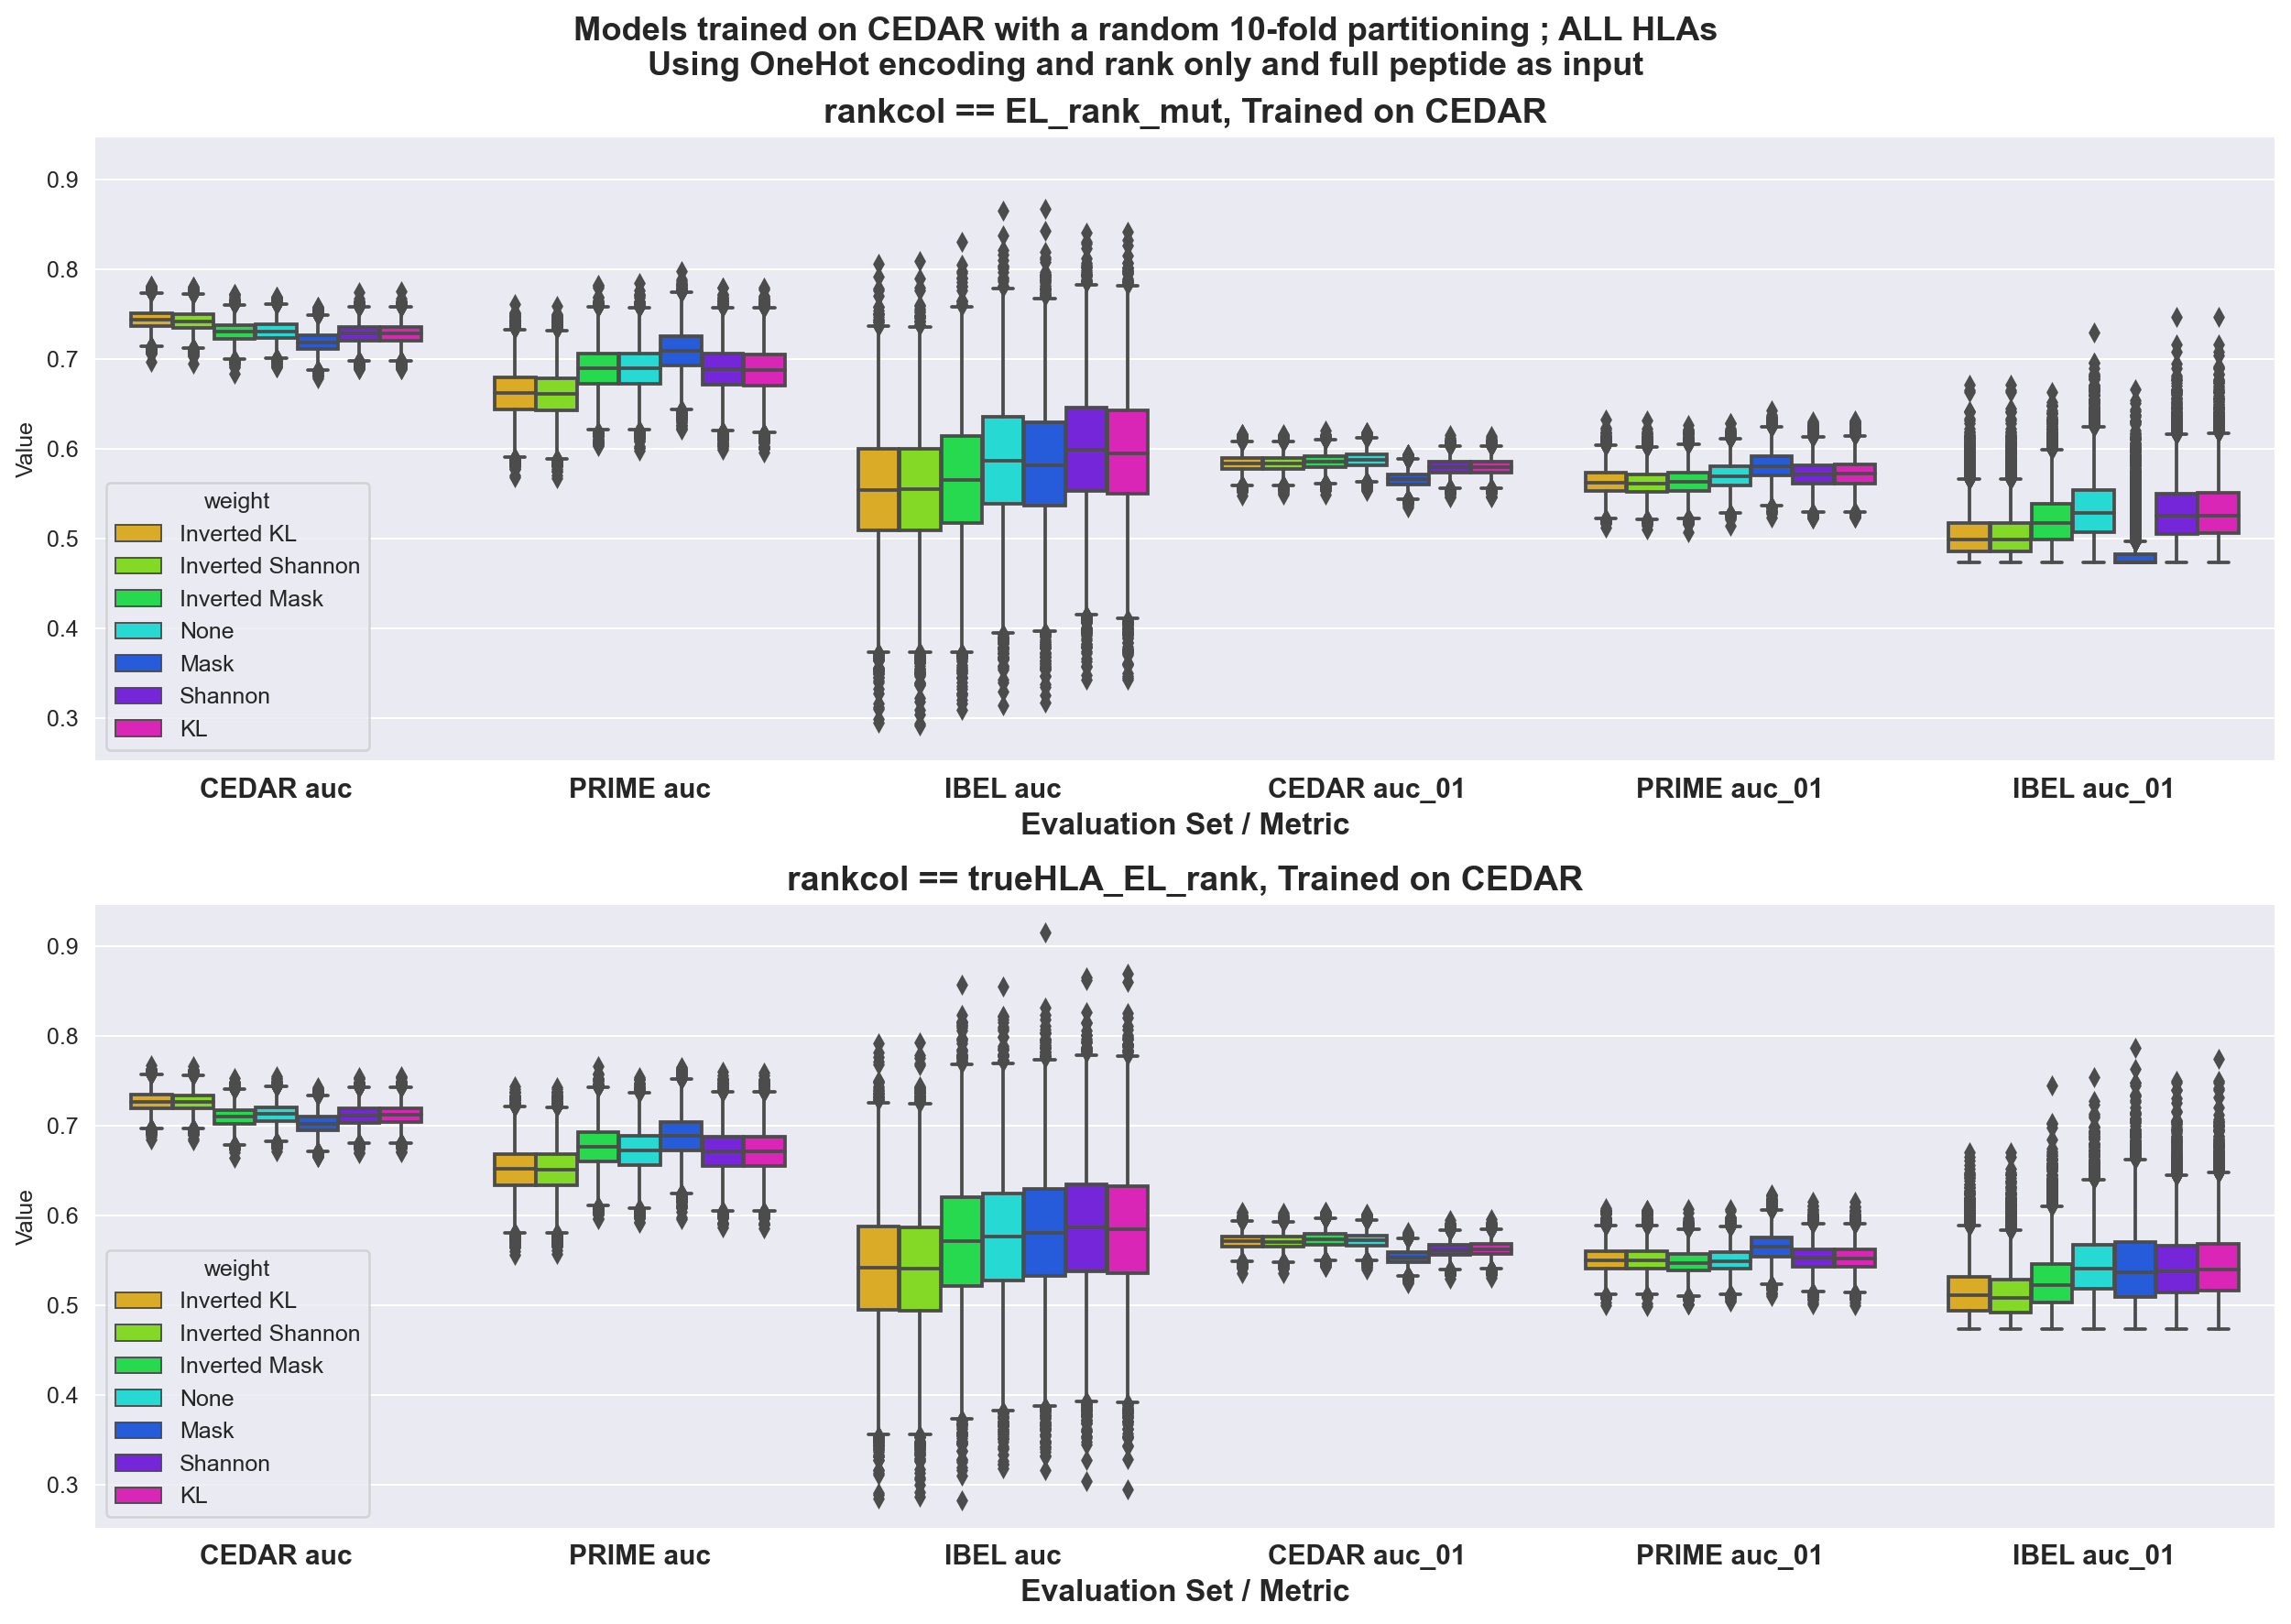

In [310]:
weight_order = ['Inverted KL', 'Inverted Shannon', 'Inverted Mask', 'None',
                'Mask', 'Shannon', 'KL']

f,a = plt.subplots(2, 1, figsize=(14,10), sharey=True)
f.suptitle('Models trained on CEDAR with a random 10-fold partitioning ; ALL HLAs\nUsing OneHot encoding and rank only and full peptide as input',
          fontweight='semibold', fontsize = 14.5)
for rankcol, axis in zip(['EL_rank_mut', 'trueHLA_EL_rank'], a.ravel()):
    
    tmp_df = pd.melt(df_randomfold.query(query+' and rank_col ==@rankcol').drop(columns = ['rank_col']),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc', 'auc_01'])
    
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'rankcol == {rankcol}, Trained on CEDAR', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12))
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')

f.tight_layout()
f.savefig('../output/hla_analysis_fixed/boxplot_fulldataset_10-randomfolds.png',
          dpi=200, bbox_inches='tight')

### No A11 boxplot

In [300]:
query='encoding == "onehot" and pep_col == "Peptide" and key == "only_rank"'

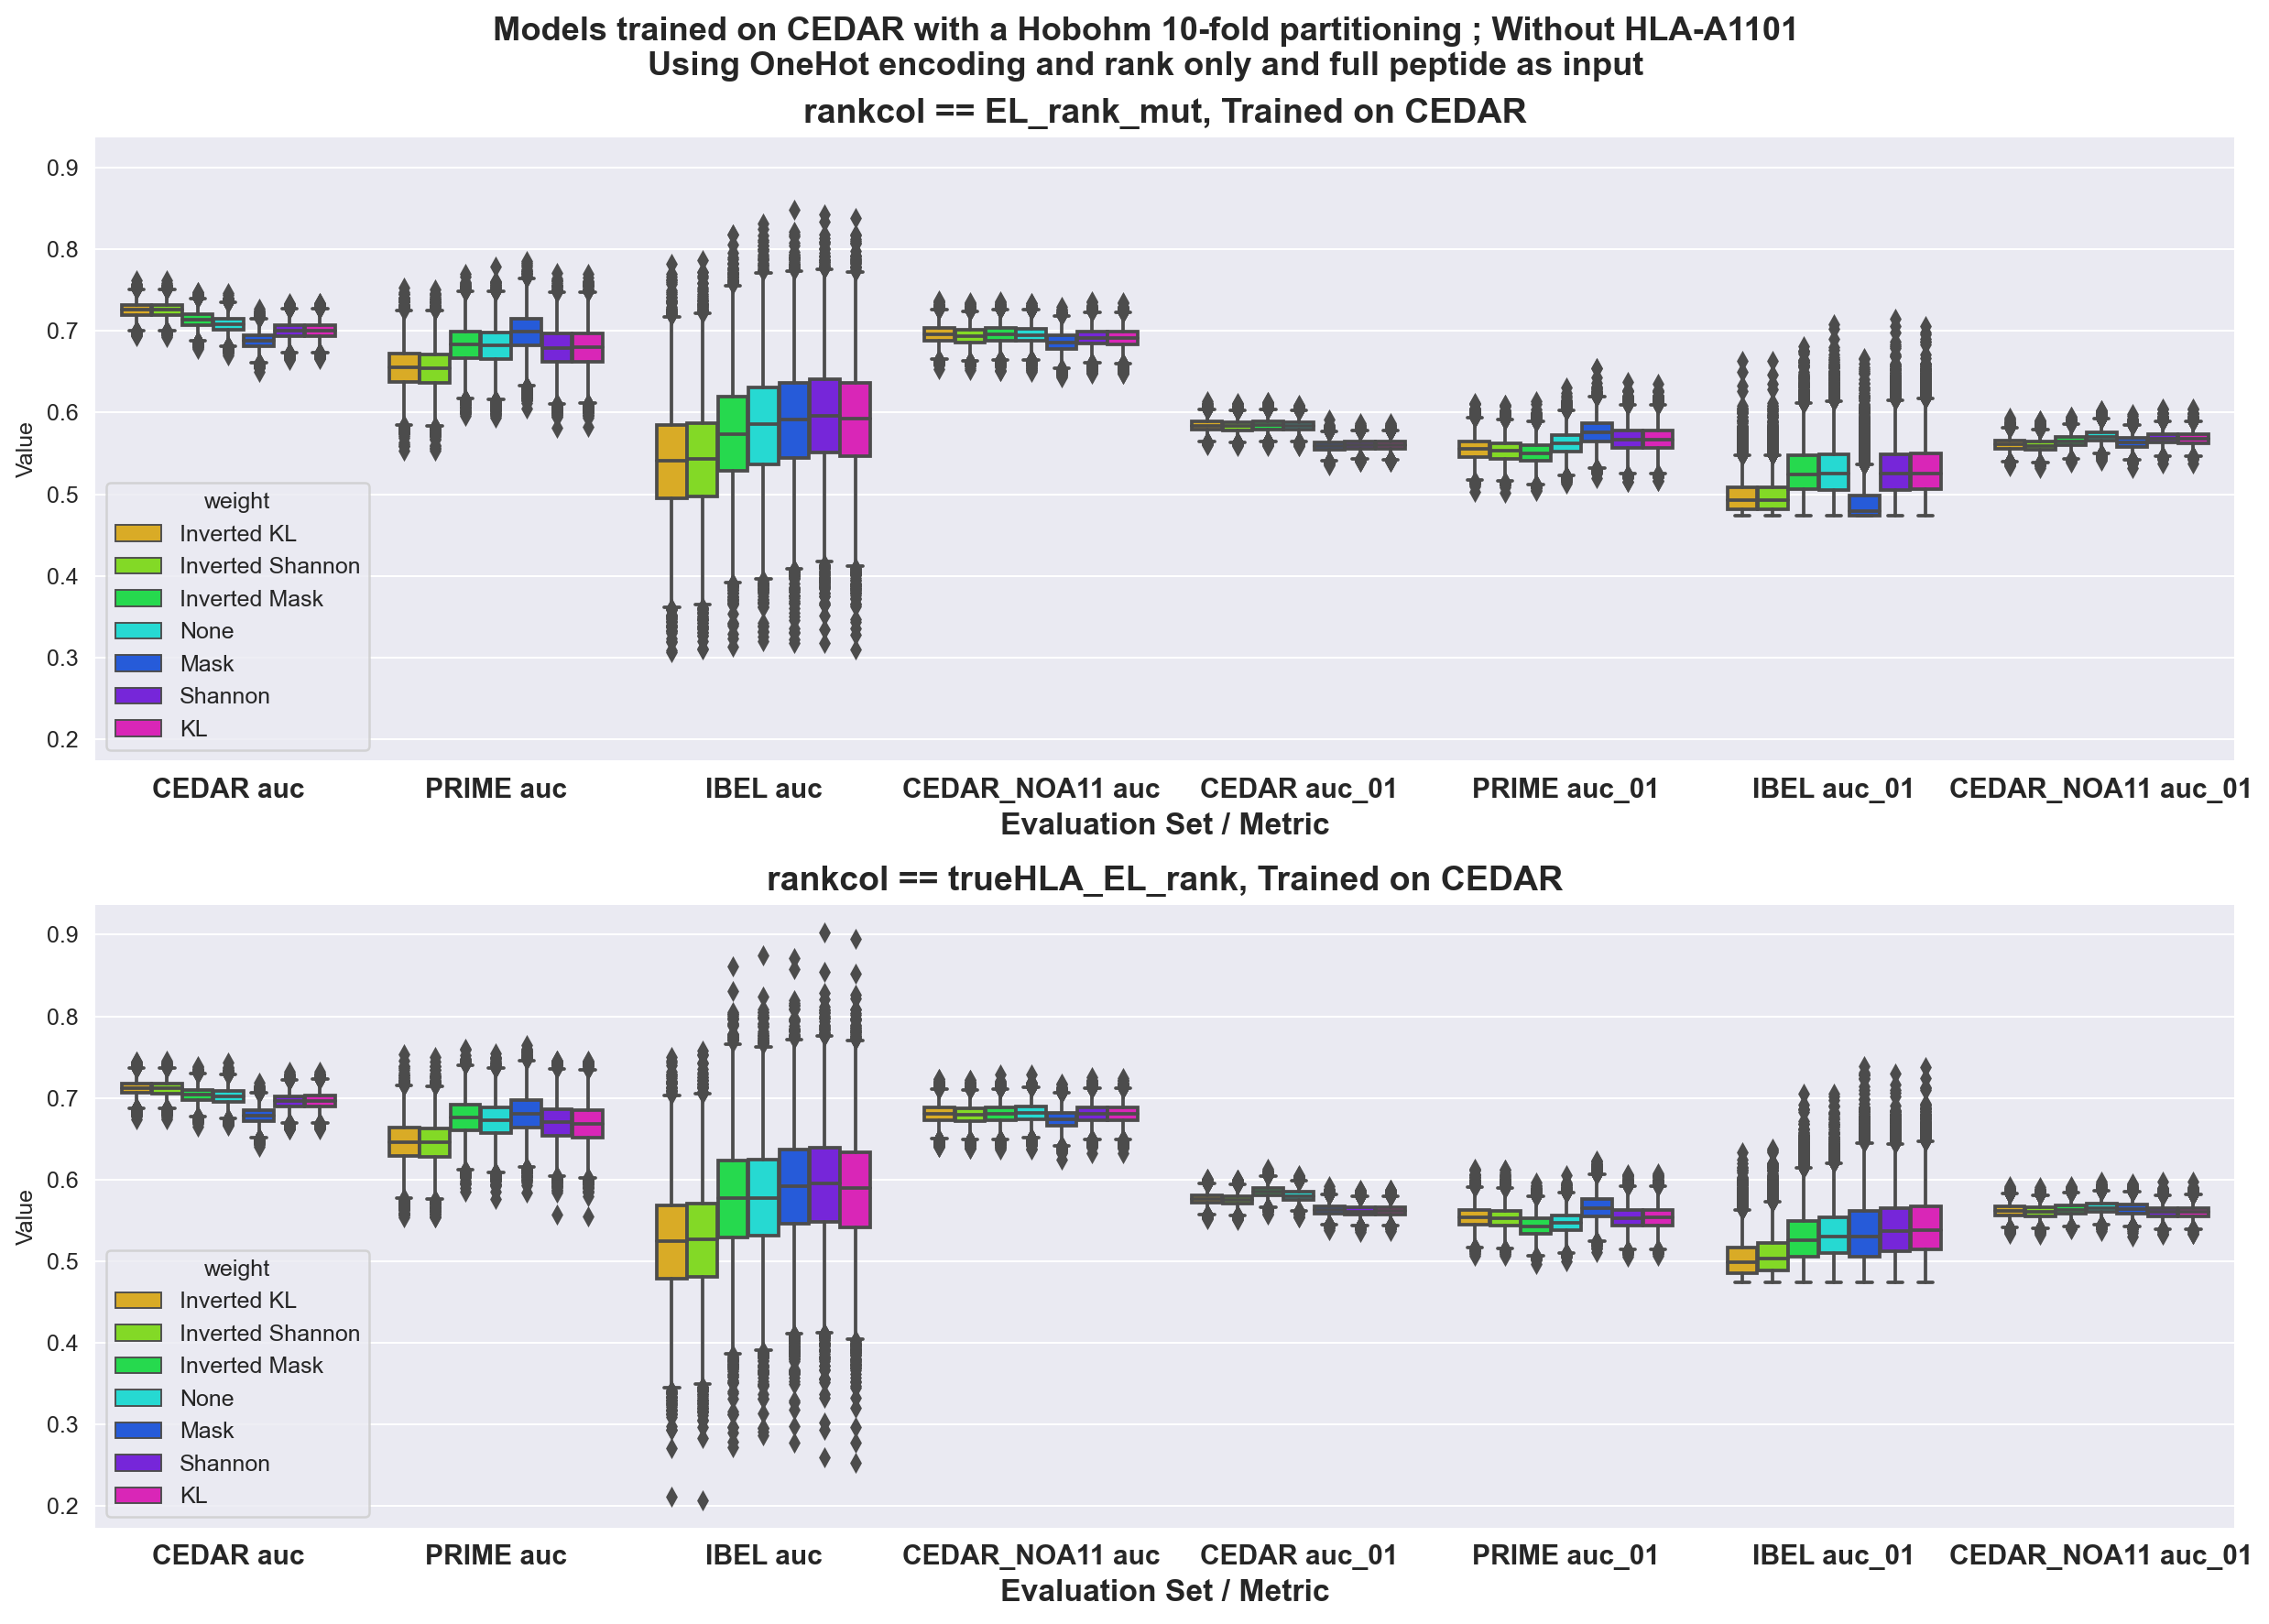

In [316]:
weight_order = ['Inverted KL', 'Inverted Shannon', 'Inverted Mask', 'None',
                'Mask', 'Shannon', 'KL']

f,a = plt.subplots(2, 1, figsize=(14,10), sharey=True)
f.suptitle('Models trained on CEDAR with a Hobohm 10-fold partitioning ; Without HLA-A1101\nUsing OneHot encoding and rank only and full peptide as input',
          fontweight='semibold', fontsize = 14.5)
for rankcol, axis in zip(['EL_rank_mut', 'trueHLA_EL_rank'], a.ravel()):
    
    tmp_df = pd.melt(df_noa11.query(query+' and rank_col ==@rankcol').drop(columns = ['rank_col']),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc', 'auc_01'])
    
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'rankcol == {rankcol}, Trained on CEDAR', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12))
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')

f.tight_layout()
f.savefig('../output/hla_analysis_fixed/boxplot_noA11_10-hobohmfolds.png',
          dpi=200, bbox_inches='tight')

## Check A11 + rest vs other Top HLAs and see if there's difference in behaviour

In [292]:
df_a11rest = pd.read_csv('../output/221229_cedar_outputs/221223_cedar_a11rest_vs_top_total_df.csv')

In [317]:
df_a11rest.columns

Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
       'encoding', 'weight', 'hla', 'evalset', 'trainset', 'key'],
      dtype='object')

In [415]:
from src.bootstrap import get_pval, plot_pval

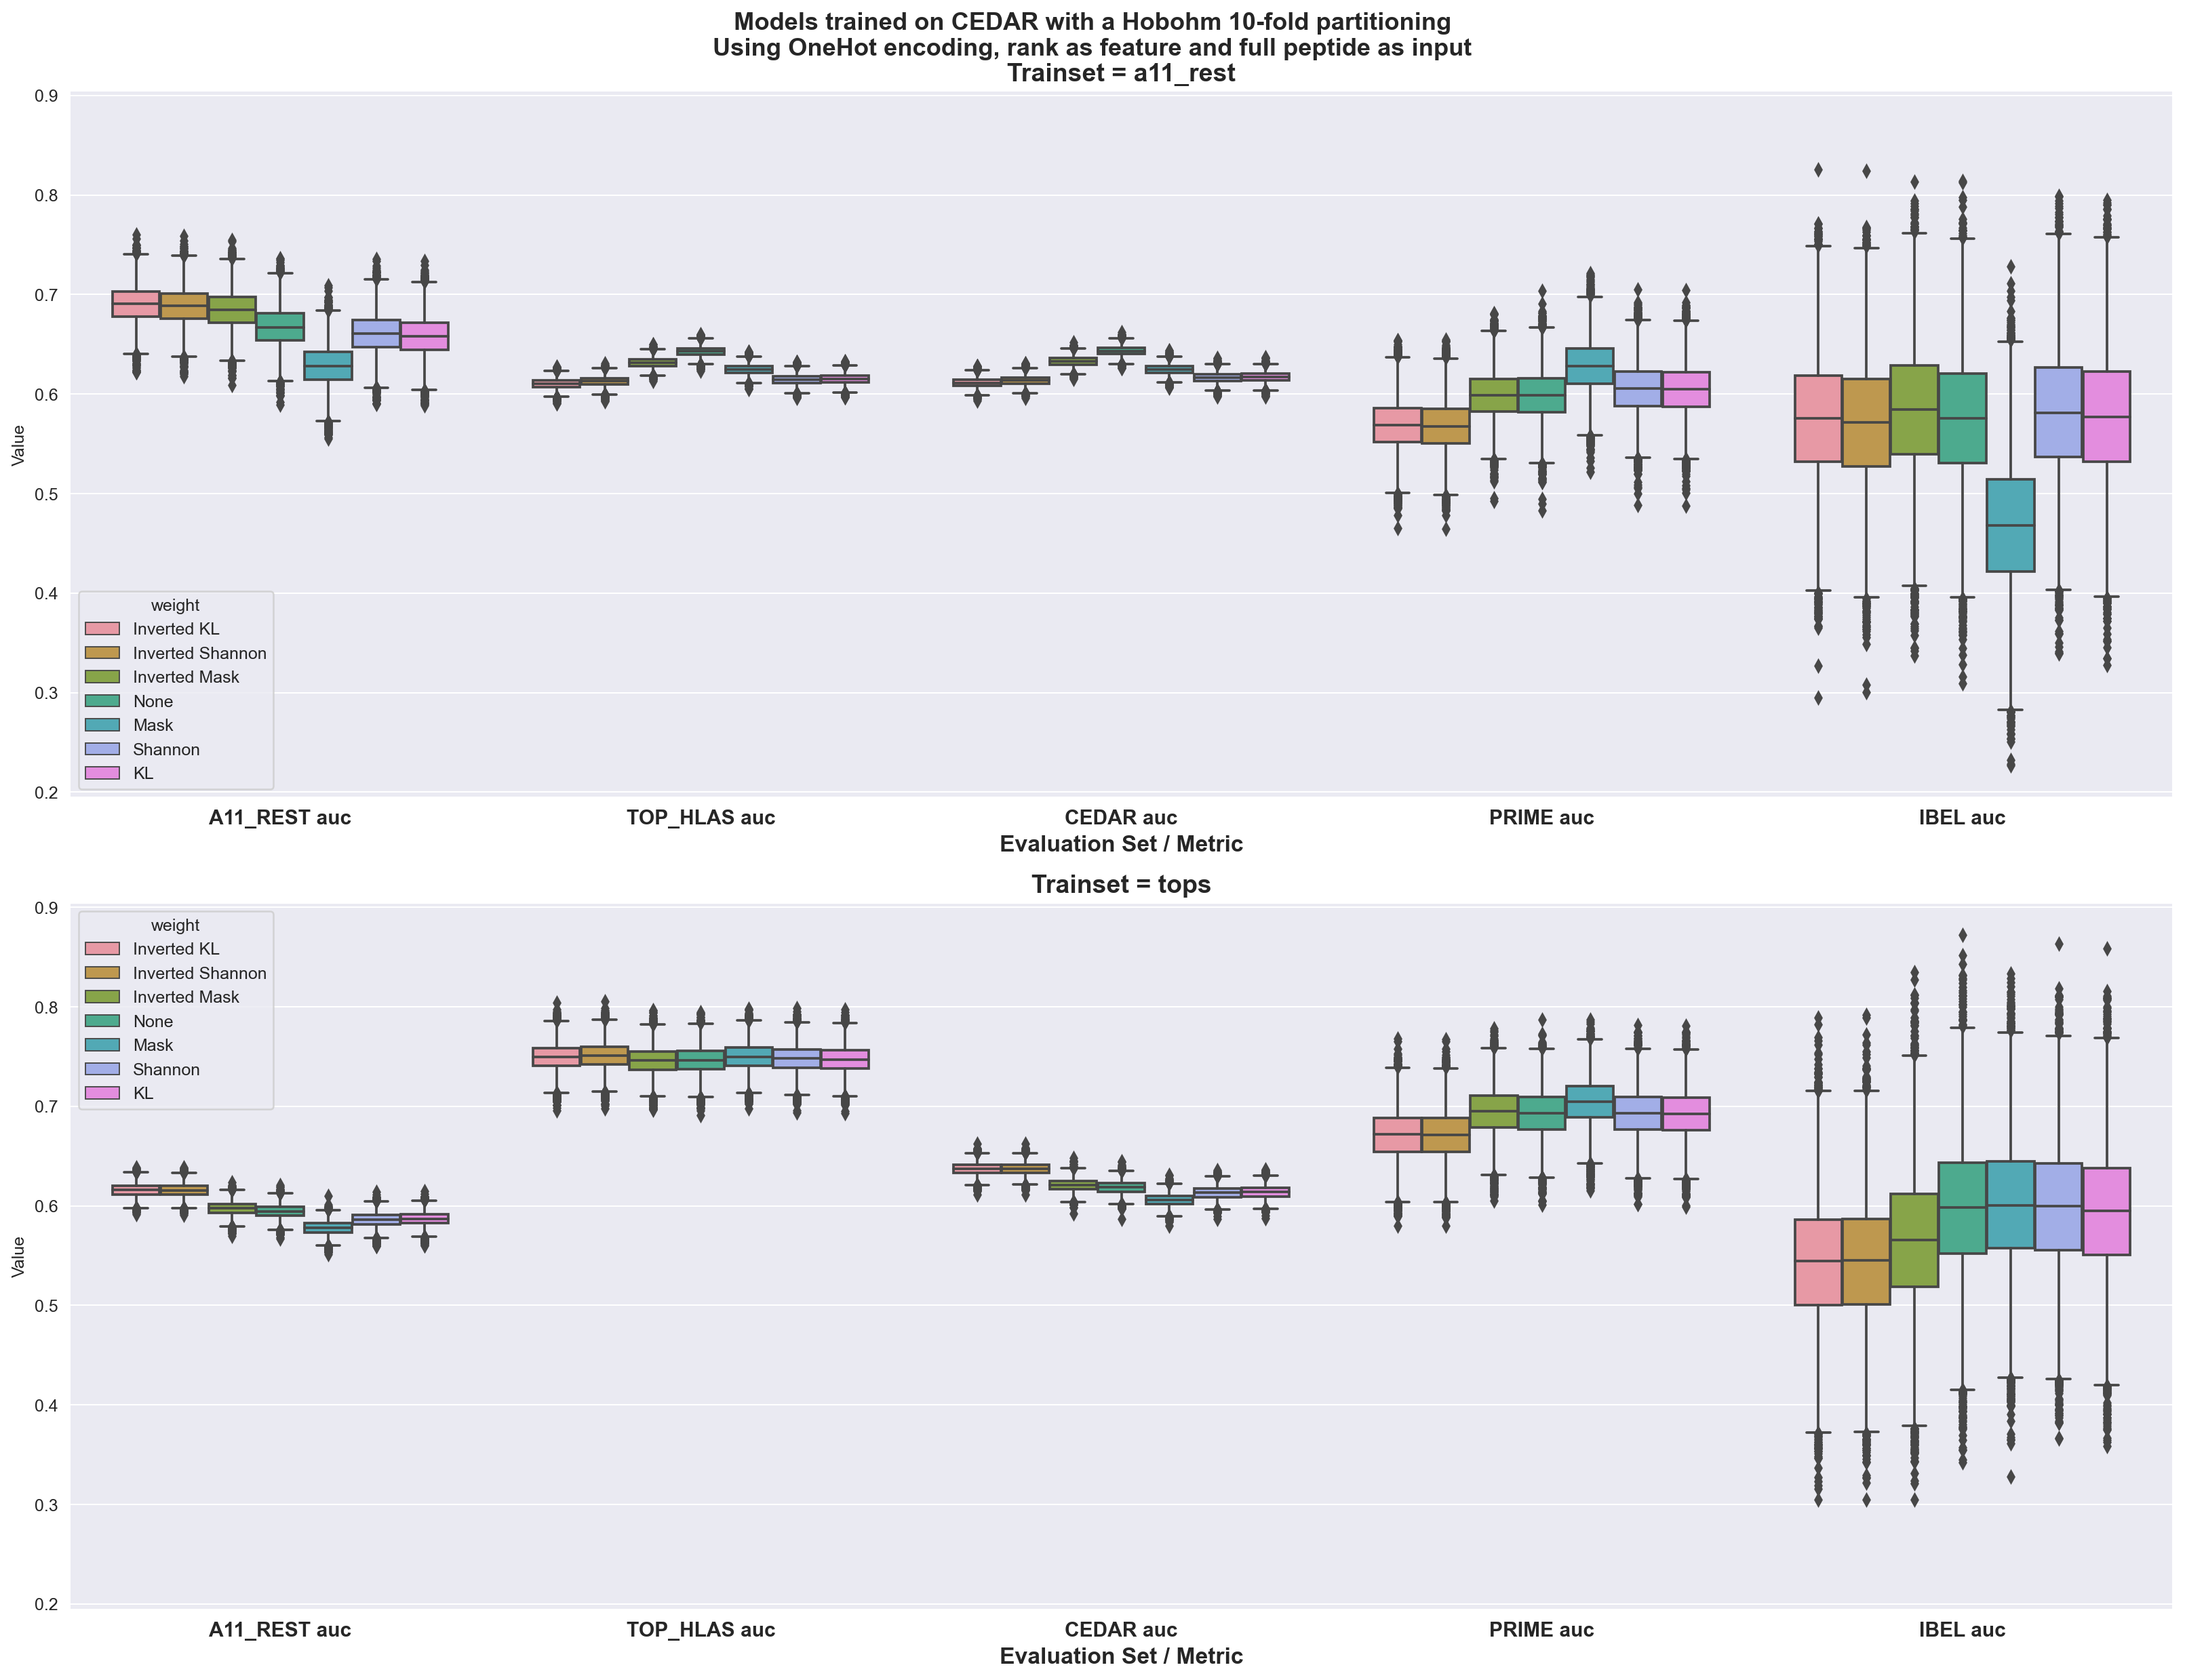

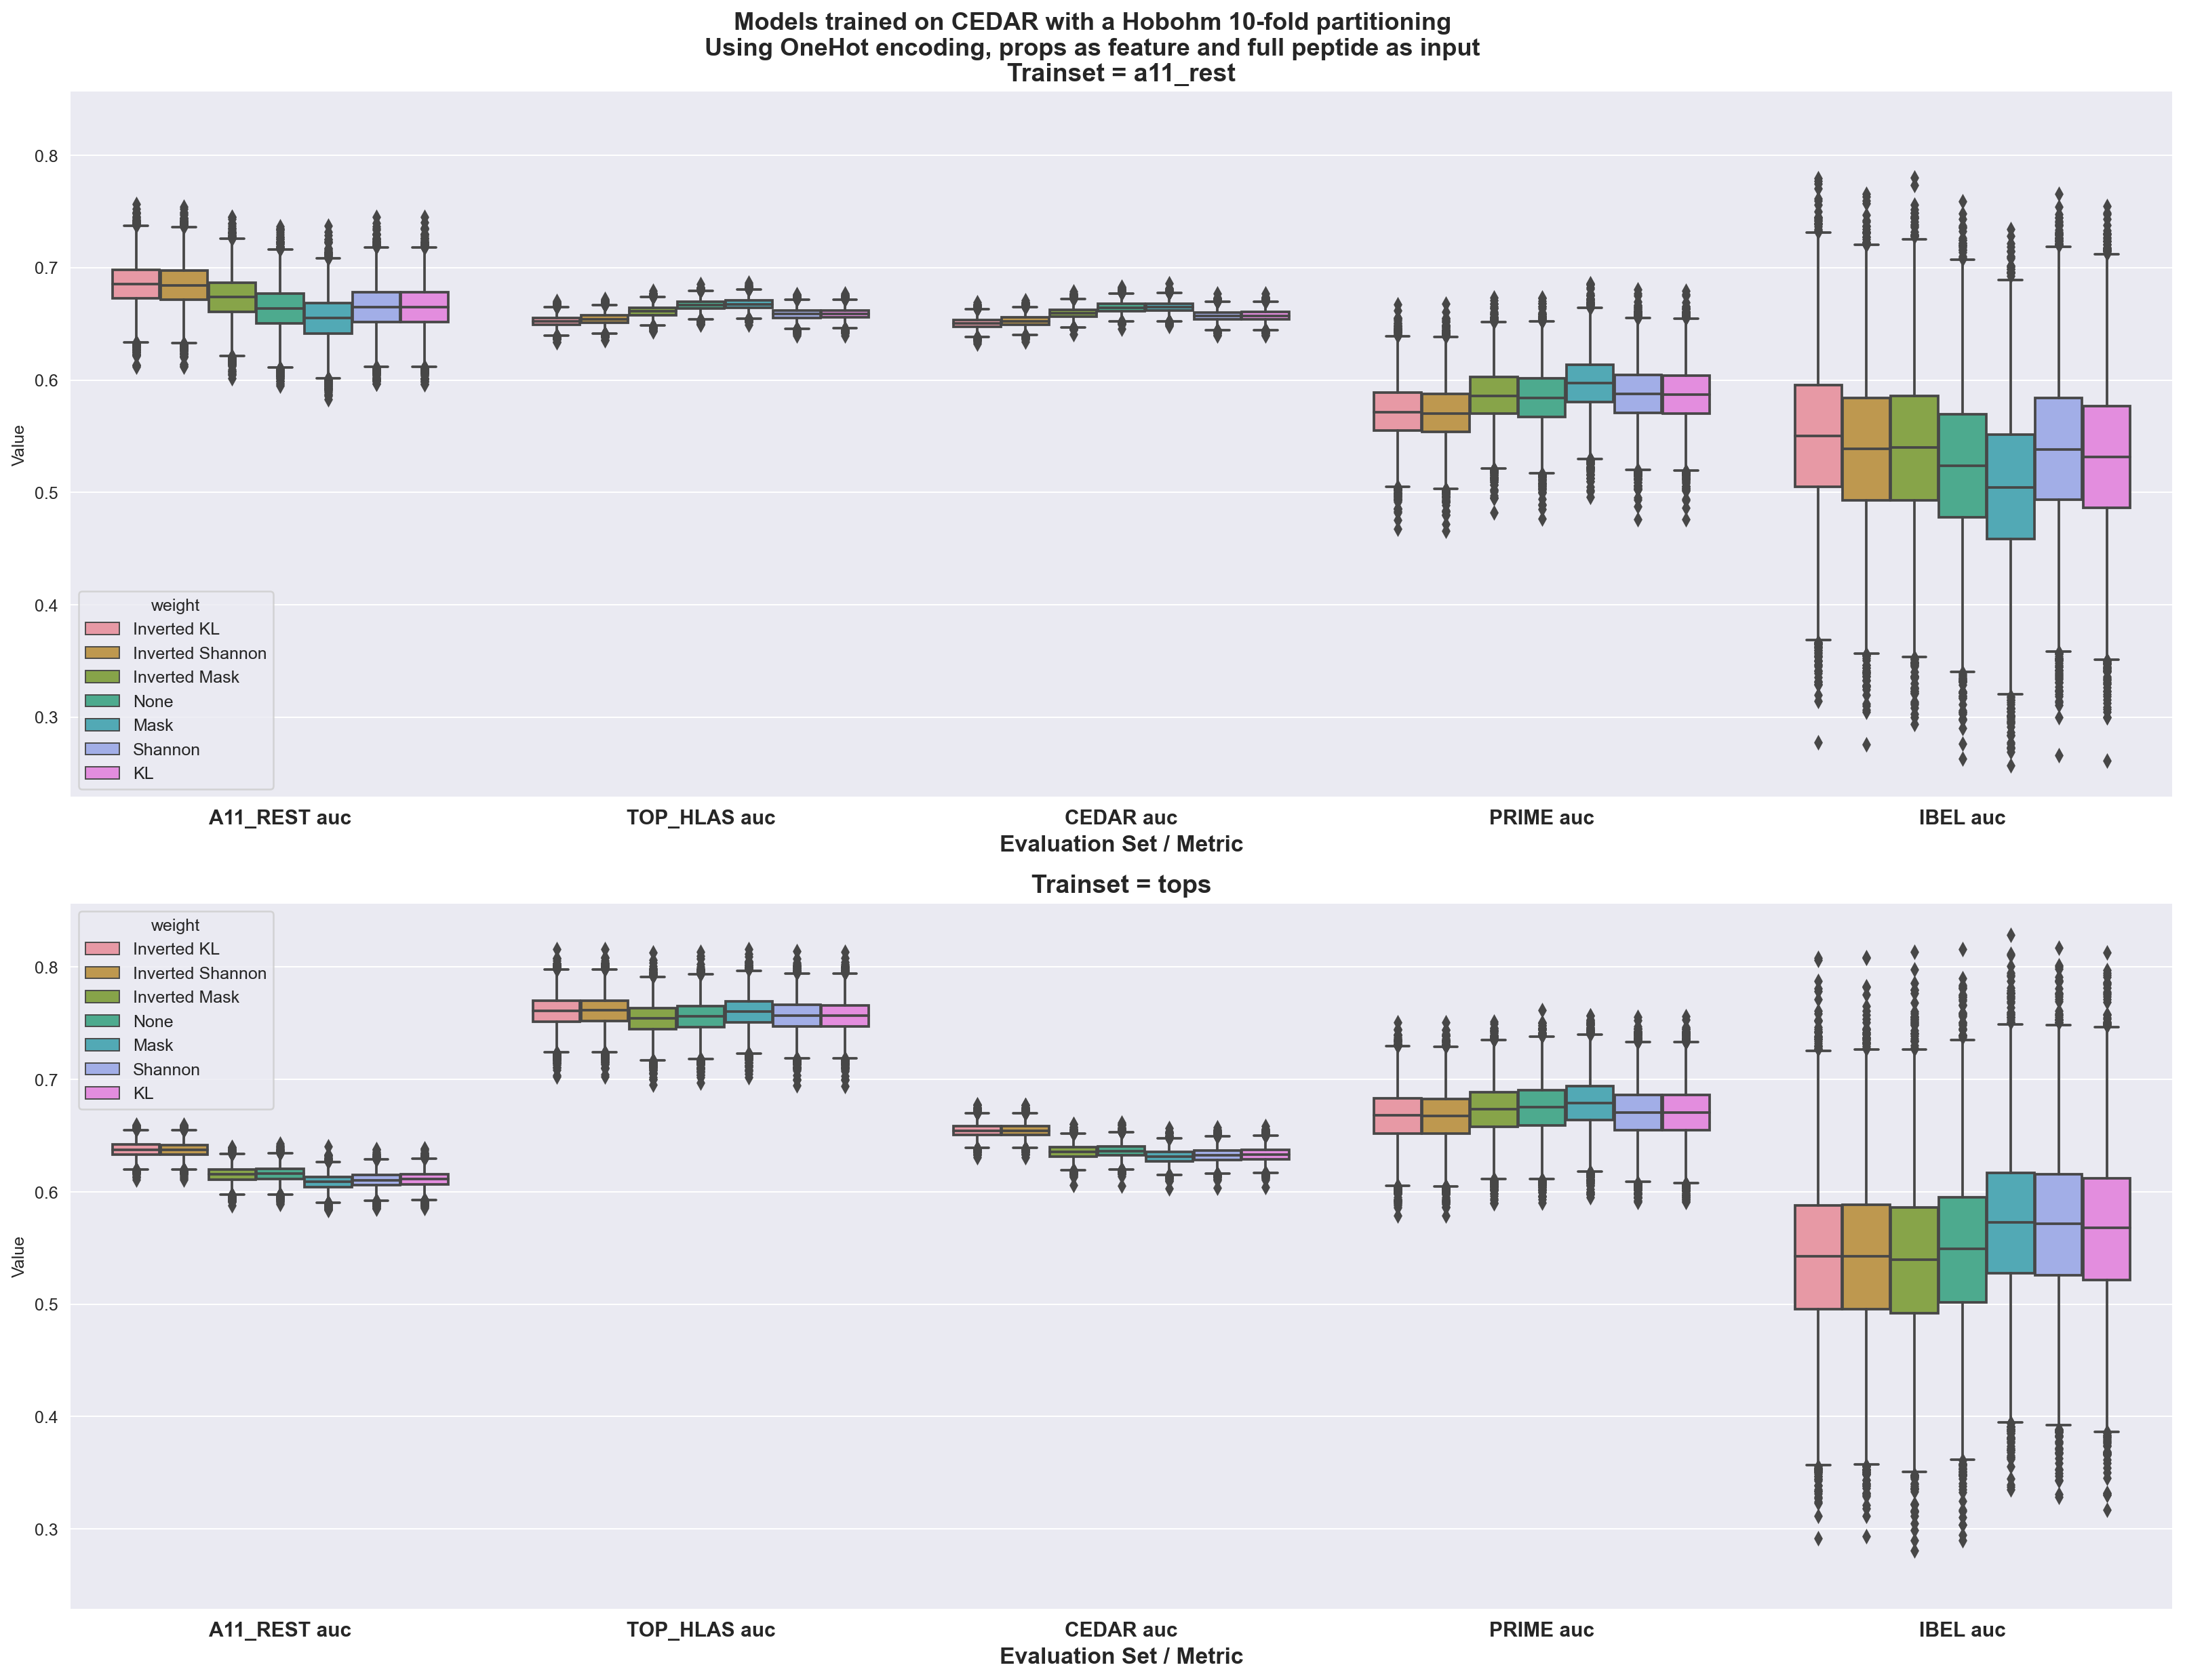

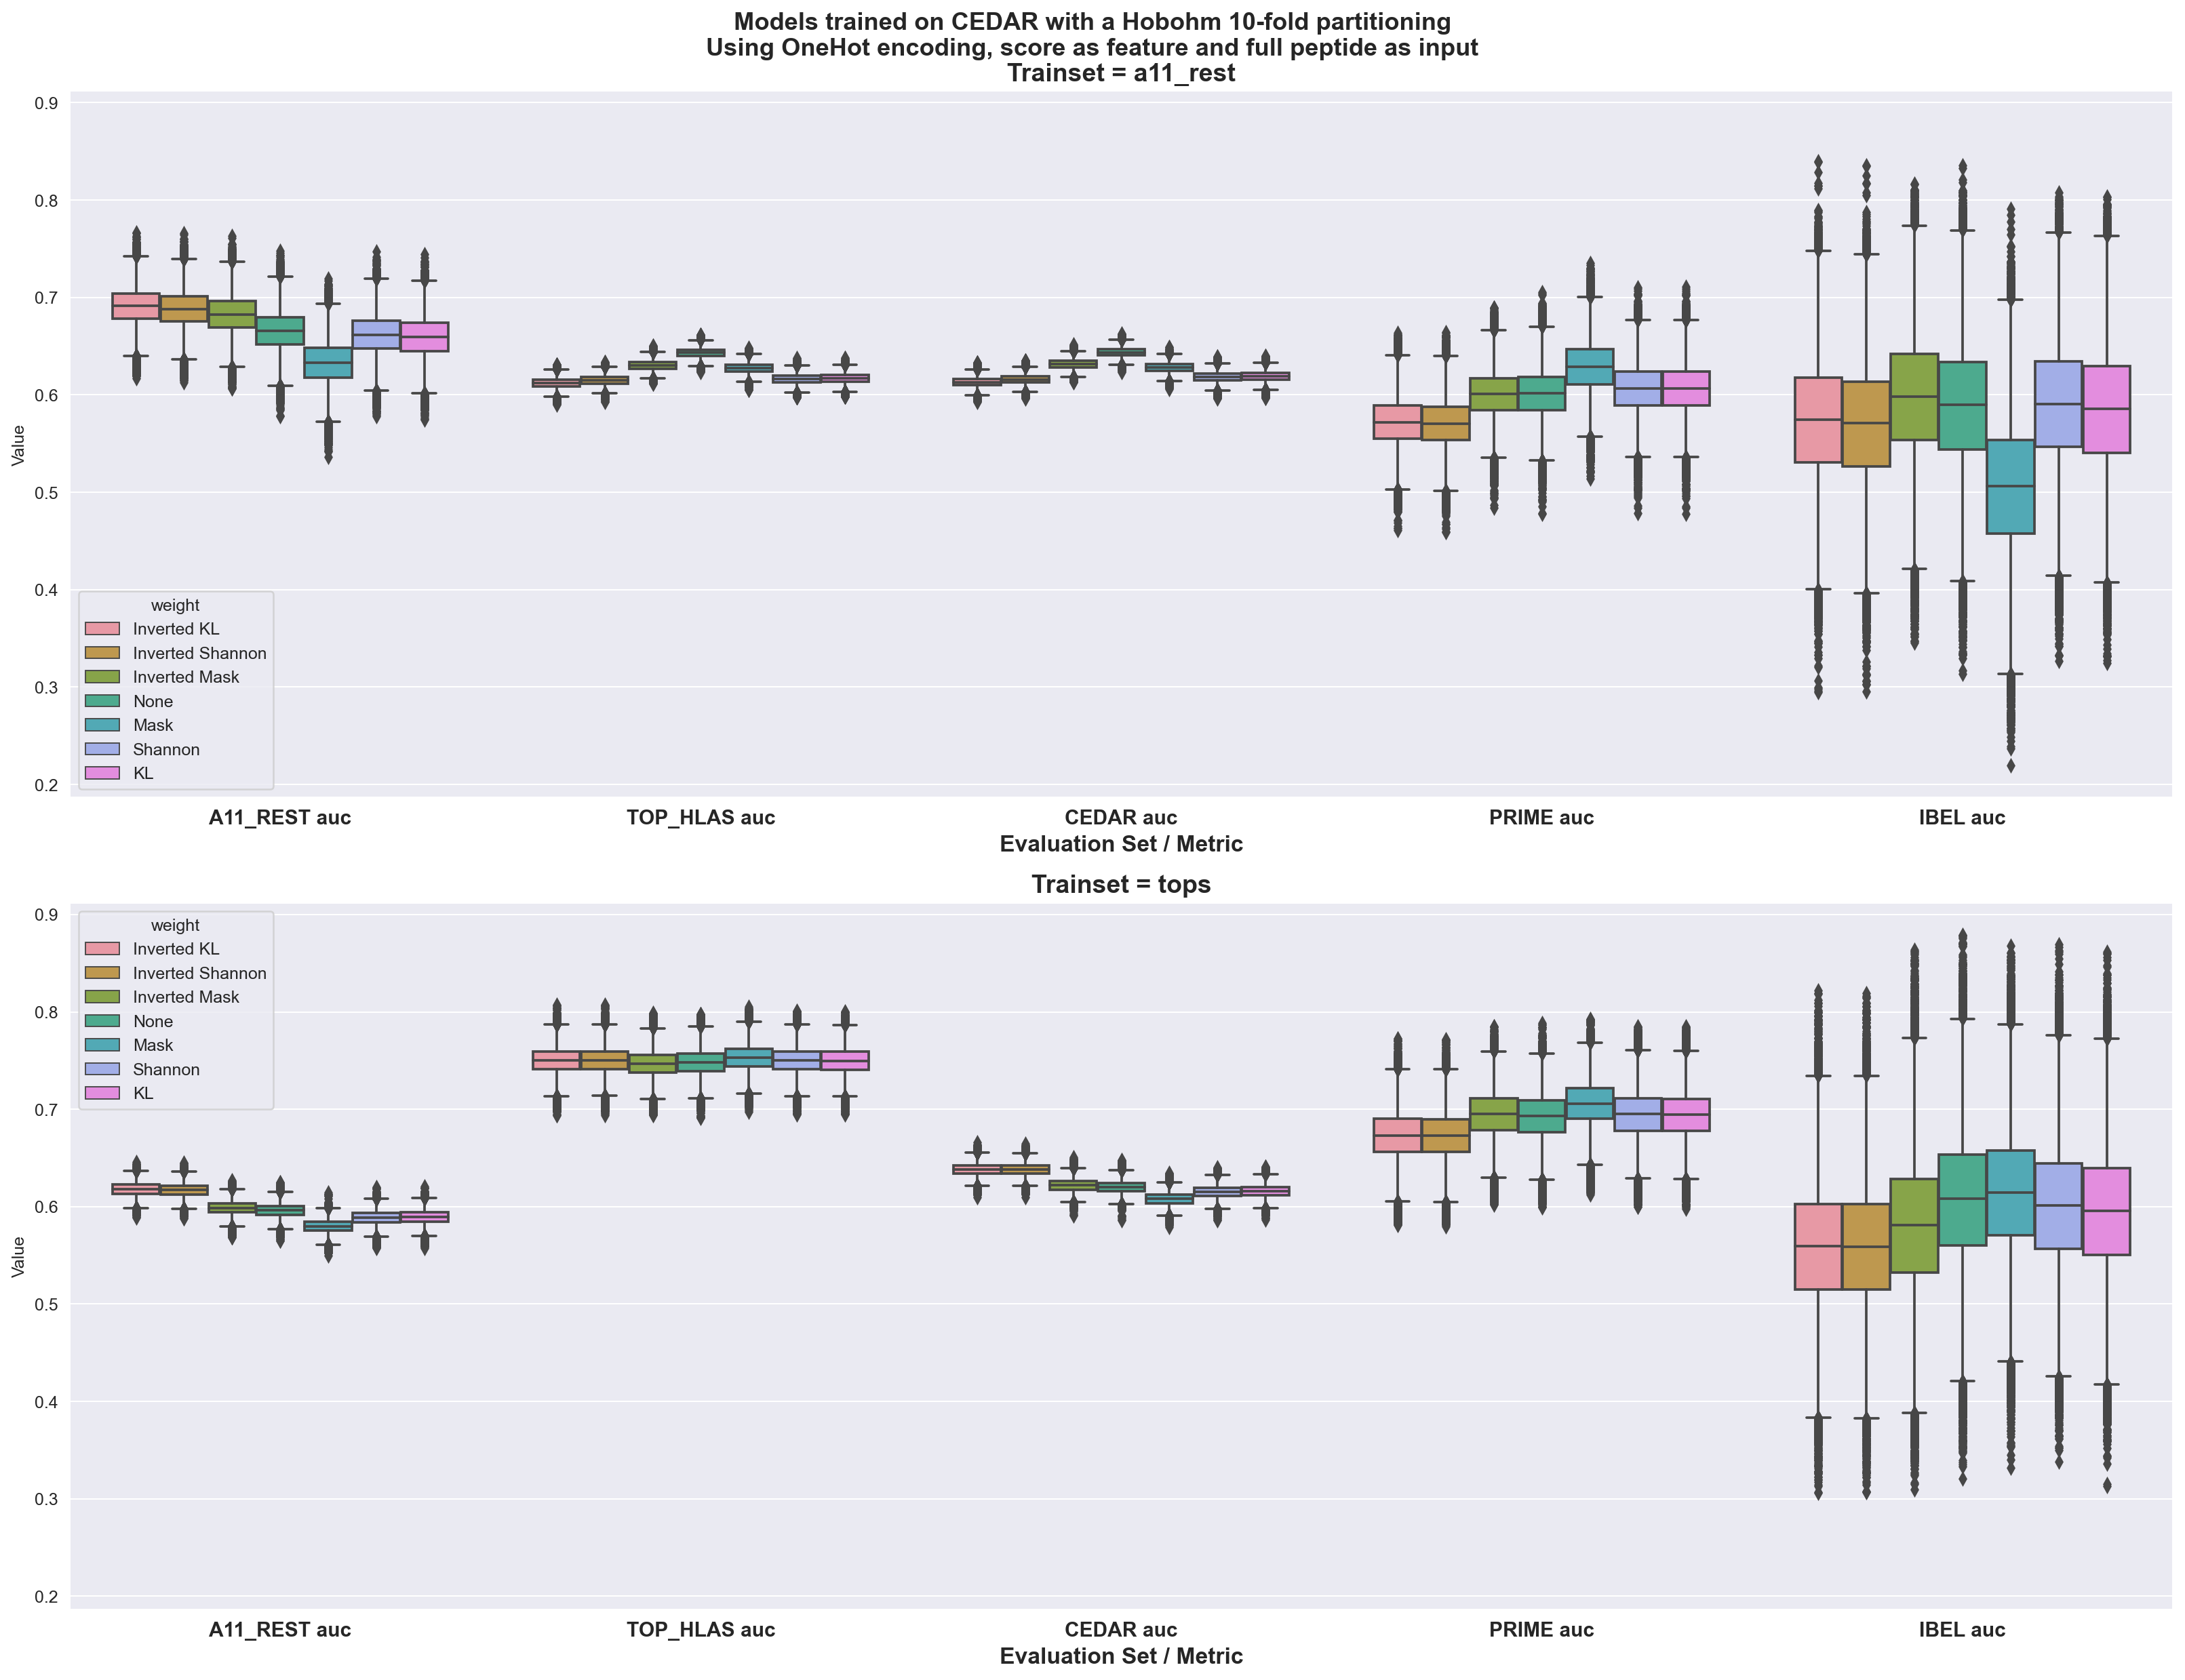

In [381]:
weight_order = ['Inverted KL', 'Inverted Shannon', 'Inverted Mask', 'None',
                'Mask', 'Shannon', 'KL']

for key in df_a11rest.key.unique():
    f,a = plt.subplots(2,1, figsize=(16,12), sharey=True)
    for hla, axis in zip(df_a11rest.hla.unique(), a.ravel()):

        tmp_df = pd.melt(df_a11rest.query('hla==@hla and key==@key').drop(columns = ['key', 'hla', 'trainset']),
                         id_vars = ['weight', 'evalset'], value_vars = ['auc'])
        tmp_df['evalset'] = tmp_df['evalset'].str.replace('CEDAR_','')
        tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
        # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
        sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
        plt.setp(axis.collections, alpha=.75)
        axis.set_title(f'Trainset = {hla}', fontweight = 'semibold', fontsize = 15)
        axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12))
        axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
        axis.set_ylabel('Value')
    
    f.suptitle(f'Models trained on CEDAR with a Hobohm 10-fold partitioning\nUsing OneHot encoding, {key} as feature and full peptide as input',
          fontweight='semibold', fontsize = 14.5)
    f.tight_layout()
    f.savefig(f'../output/hla_analysis_fixed/boxplot_A11rest_{key}.png',
              dpi=200, bbox_inches='tight')

In [421]:
df_a11rest['trainset'] = df_a11rest['trainset'].str.replace('CEDAR_TOPS','CEDAR_TOP_HLAS')

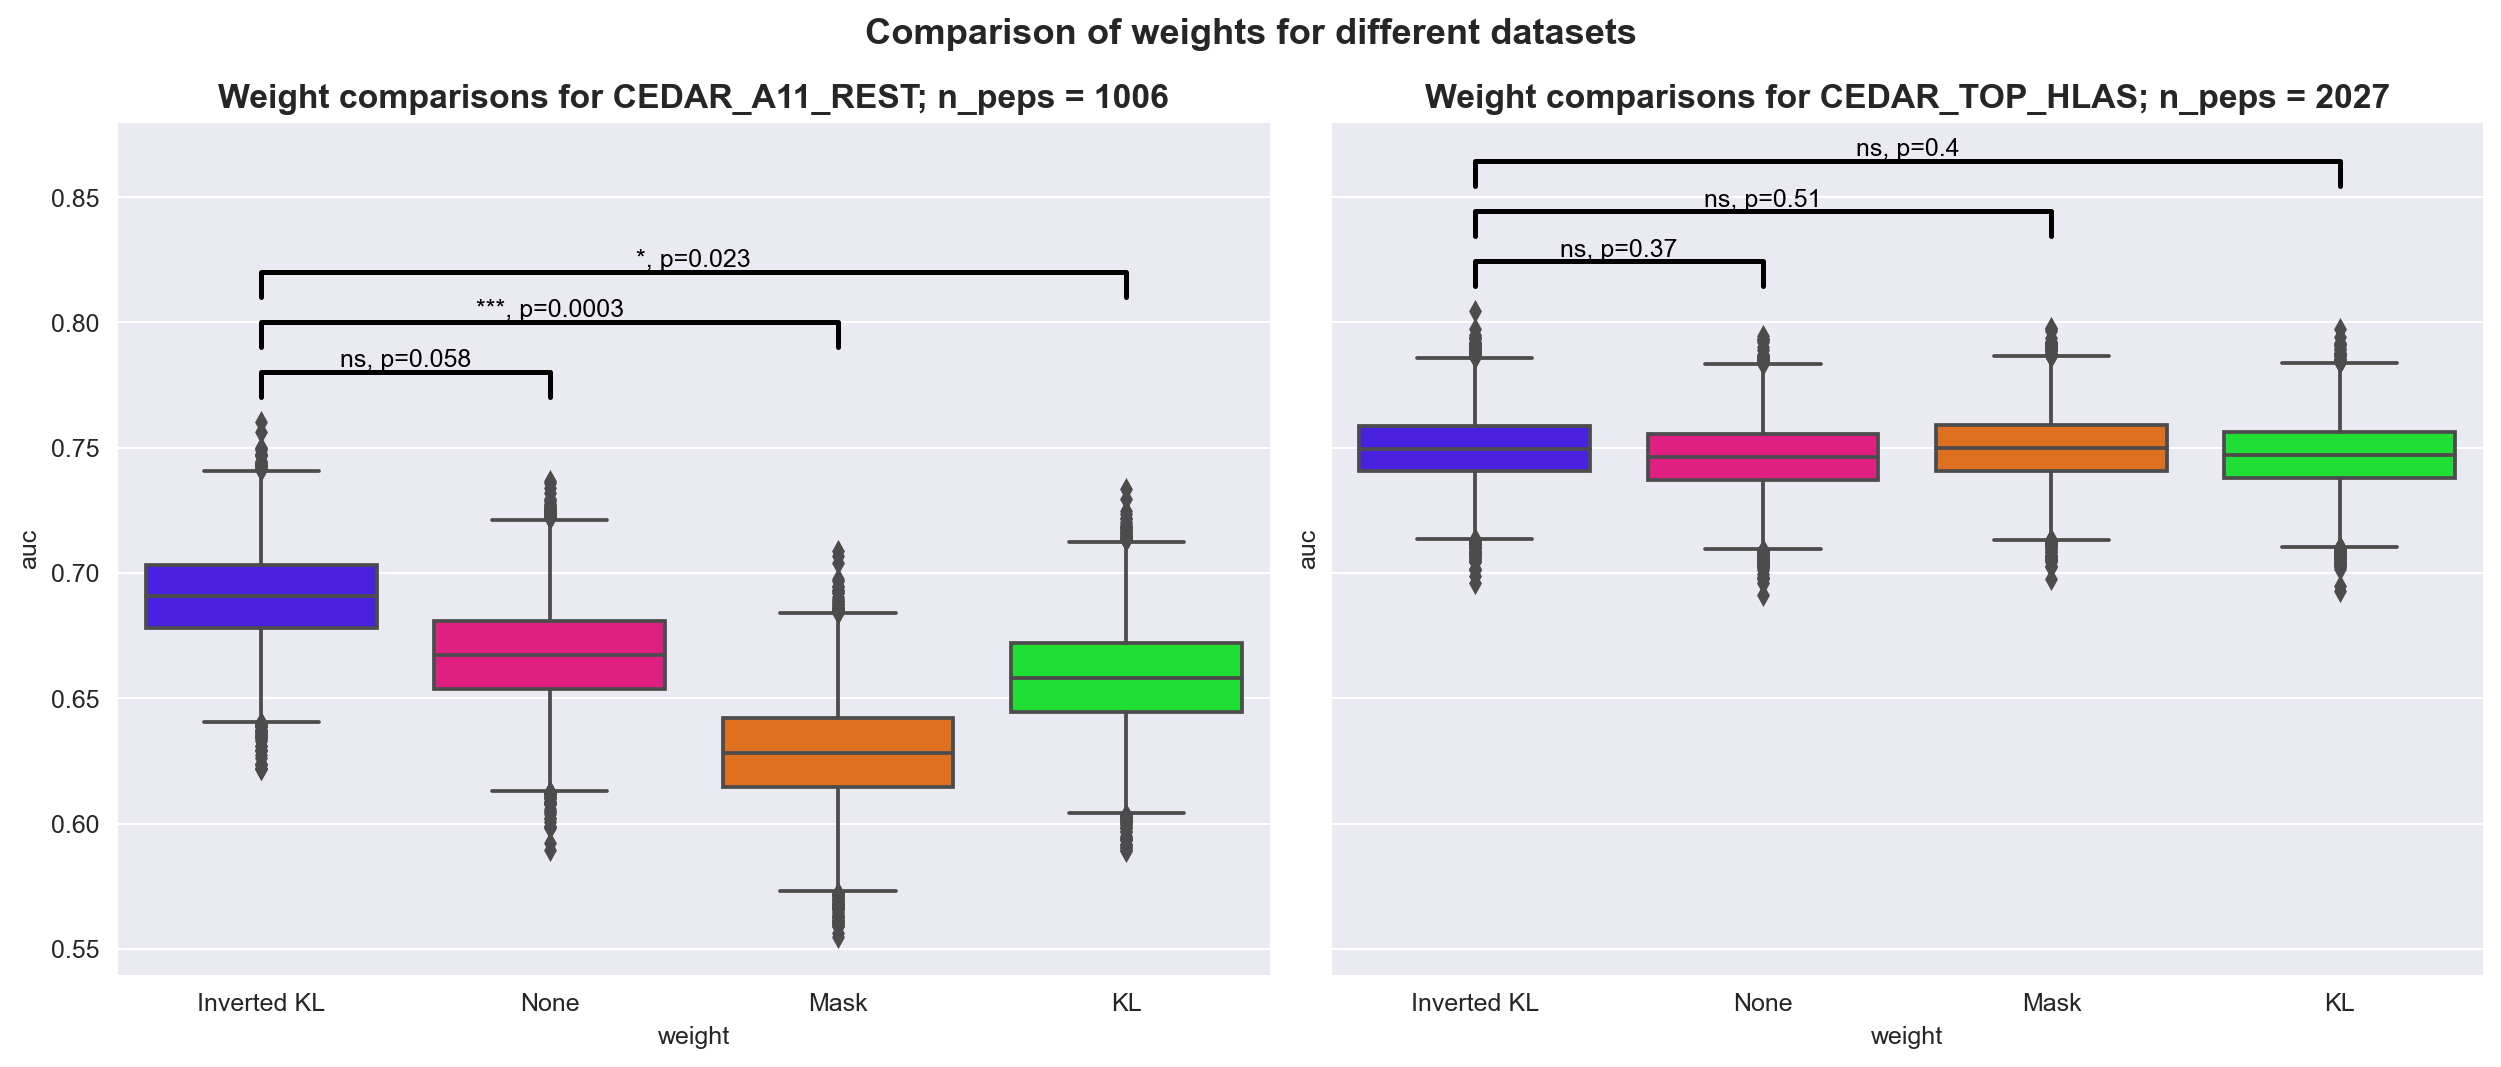

In [435]:
f,a = plt.subplots(1,2, figsize=(14,6), sharey=True)
x_order = ['Inverted KL','None','Mask','KL']
sns.set_palette(HSV)
for trainset, axis in zip(df_a11rest.trainset.unique(), a.ravel()):
    tmp = df_a11rest.query('trainset==@trainset and evalset==@trainset and key=="rank"') 
    sns.boxplot(data=tmp, y='auc', x = 'weight', order=x_order, ax=axis)
    aucs_invkl = tmp.query('weight=="Inverted KL"').auc.values
    h0 = 0.01
    h = h0
    x0 = 0
    x2 = 1
    for comparison in x_order[1:]:
        aucs_comp = tmp.query('weight==@comparison').auc.values
        pval, sig = get_pval(aucs_invkl, aucs_comp)
        plot_pval(axis, pval, sig, 0, x2, y = max(aucs_invkl)+h, h=h0)
                             
        x2 += 1
        h += 2*h0
    n_pep = len(cedar_a11_rest_fold) if trainset == "CEDAR_A11_REST" else len(cedar_tops_fold)
    axis.set_title(f'Weight comparisons for {trainset}; n_peps = {n_pep}', fontweight='semibold', fontsize=13.5)
f.suptitle('Comparison of weights for different datasets',
          fontsize=14.5, fontweight='semibold')
f.tight_layout()
f.savefig('../output/230104_boxplots_pvalues/boxplot_weight_pvalues_A11rest_vs_top.png', dpi=200, bbox_inches='tight')

## A11rest shuffle

In [458]:
cedar_a11_rest_fold['hla_new'] = cedar_a11_rest_fold['HLA'].apply(lambda x: x=='HLA-A1101')
cedar_a11_rest_fold.groupby(['fold', 'hla_new', 'agg_label']).count()

Peptide  HLA  trueHLA_EL_rank  EL_rank_mut  \
fold hla_new agg_label                                               
0    False   0               53   53               53           53   
             1               29   29               29           29   
     True    0               26   26               26           26   
             1                1    1                1            1   
1    False   0               56   56               56           56   
             1               20   20               20           20   
     True    0               23   23               23           23   
             1                4    4                4            4   
2    False   0               51   51               51           51   
             1               23   23               23           23   
     True    0               20   20               20           20   
             1                5    5                5            5   
3    False   0               61   61               61           61   
             1               20   20               20           20   
     True    0               10   10               10           10   
4    False   0               53   53               53           53   
             1               23   23               23           23   
     True    0               22   22               22           22   
             1                2    2                2            2   
5    False   0               53   53               53           53   
             1               15   15               15           15   
     True    0               19   19               19           19   
             1                5    5                5            5   
6    False   0               60   60               60           60   
             1               23   23               23           23   
     True    0               14   14               14           14   
             1                4    4                4            4   
7    False   0               51   51               51           51   
             1               17   17               17           17   
     True    0               32   32               32           32   
             1                3    3                3            3   
8    False   0               52   52               52           52   
             1               20   20               20           20   
     True    0               31   31               31           31   
             1                1    1                1            1   
9    False   0               55   55               55           55   
             1               19   19               19           19   
     True    0               25   25               25           25   
             1                5    5                5            5   

                        EL_rank_wt  PMIDs  Peptide_mut  Peptide_wt  Pos_mut  \
fold hla_new agg_label                                                        
0    False   0                  53     53           53          53       53   
             1                  29     29           29          29       29   
     True    0                  26     26           26          26       26   
             1                   1      1            1           1        1   
1    False   0                  56     56           56          56       56   
             1                  20     20           20          20       20   
     True    0                  23     23           23          23       23   
             1                   4      4            4           4        4   
2    False   0                  51     51           51          51       51   
             1                  23     23           23          23       23   
     True    0                  20     20           20          20       20   
             1                   5      5            5           5        5   
3    False   0                  61     61      

In [460]:
cedar_a11_rest_fold.query('HLA=="HLA-A1101"').groupby(['agg_label']).count()

Peptide  HLA  trueHLA_EL_rank  fold  EL_rank_mut  EL_rank_wt  \
agg_label                                                                 
0              222  222              222   222          222         222   
1               30   30               30    30           30          30   

           PMIDs  Peptide_mut  Peptide_wt  Pos_mut  ...  percentage_pos  \
agg_label                                           ...                   
0            222          222         222      222  ...             222   
1             30           30          30       30  ...              30   

           ratio_rank  responses  total_count  trainset  wild_type  \
agg_label                                                            
0                 222        222          222       222        222   
1                  30         30           30        30         30   

           wt_EL_rank  wt_core  wt_true  hla_new  
agg_label                                         
0                 222      222      222      222  
1                  30       30       30       30  

[2 rows x 56 columns]

In [469]:
nn_df = pd.read_csv('../output/221227_mutscores_NN_cedar_total_df/total_df.csv')
for evalset in nn_df.evalset.unique():
    print(evalset)
    display(nn_df.query('evalset==@evalset').groupby(['encoding', 'weight','rank_col', 'pep_col', 'key']).agg(mean_auc = ('auc','mean')).sort_values('mean_auc', ascending=False).head(3))

CEDAR


mean_auc
encoding weight           rank_col    pep_col key               
BL62FREQ Inverted KL      EL_rank_mut Peptide aa_props  0.685716
         Inverted Shannon EL_rank_mut Peptide aa_props  0.684450
onehot   Inverted Shannon EL_rank_mut Peptide aa_props  0.678215

PRIME


mean_auc
encoding weight  rank_col    pep_col key                                                         
BL62LO   KL      EL_rank_mut Peptide dissimilarity_score-core_blsm_mut_score-core_mu...  0.597897
         Shannon EL_rank_mut Peptide dissimilarity_score-core_blsm_mut_score-core_mu...  0.597774
         KL      EL_rank_mut Peptide core_blsm_mut_score-core_mutation_score             0.597202

PRIME_AC


mean_auc
encoding weight rank_col    pep_col key                                                        
onehot   Mask   EL_rank_mut Peptide dissimilarity_score-blsm_mut_score-mutation_score  0.592291
                                    blsm_mut_score                                     0.588789
                                    blsm_mut_score-mutation_score                      0.587822

IBEL


mean_auc
encoding weight           rank_col    pep_col key                                                        
BL62LO   Inverted KL      EL_rank_mut Peptide dissimilarity_score-blsm_mut_score-mutation_score  0.646293
                                              blsm_mut_score-mutation_score                      0.643346
         Inverted Shannon EL_rank_mut Peptide blsm_mut_score-mutation_score                      0.643021

### results

In [471]:
df_a11shuffle = pd.read_csv('../output/230106_cedar_a11rest_posnegshuffle/total_df.csv')


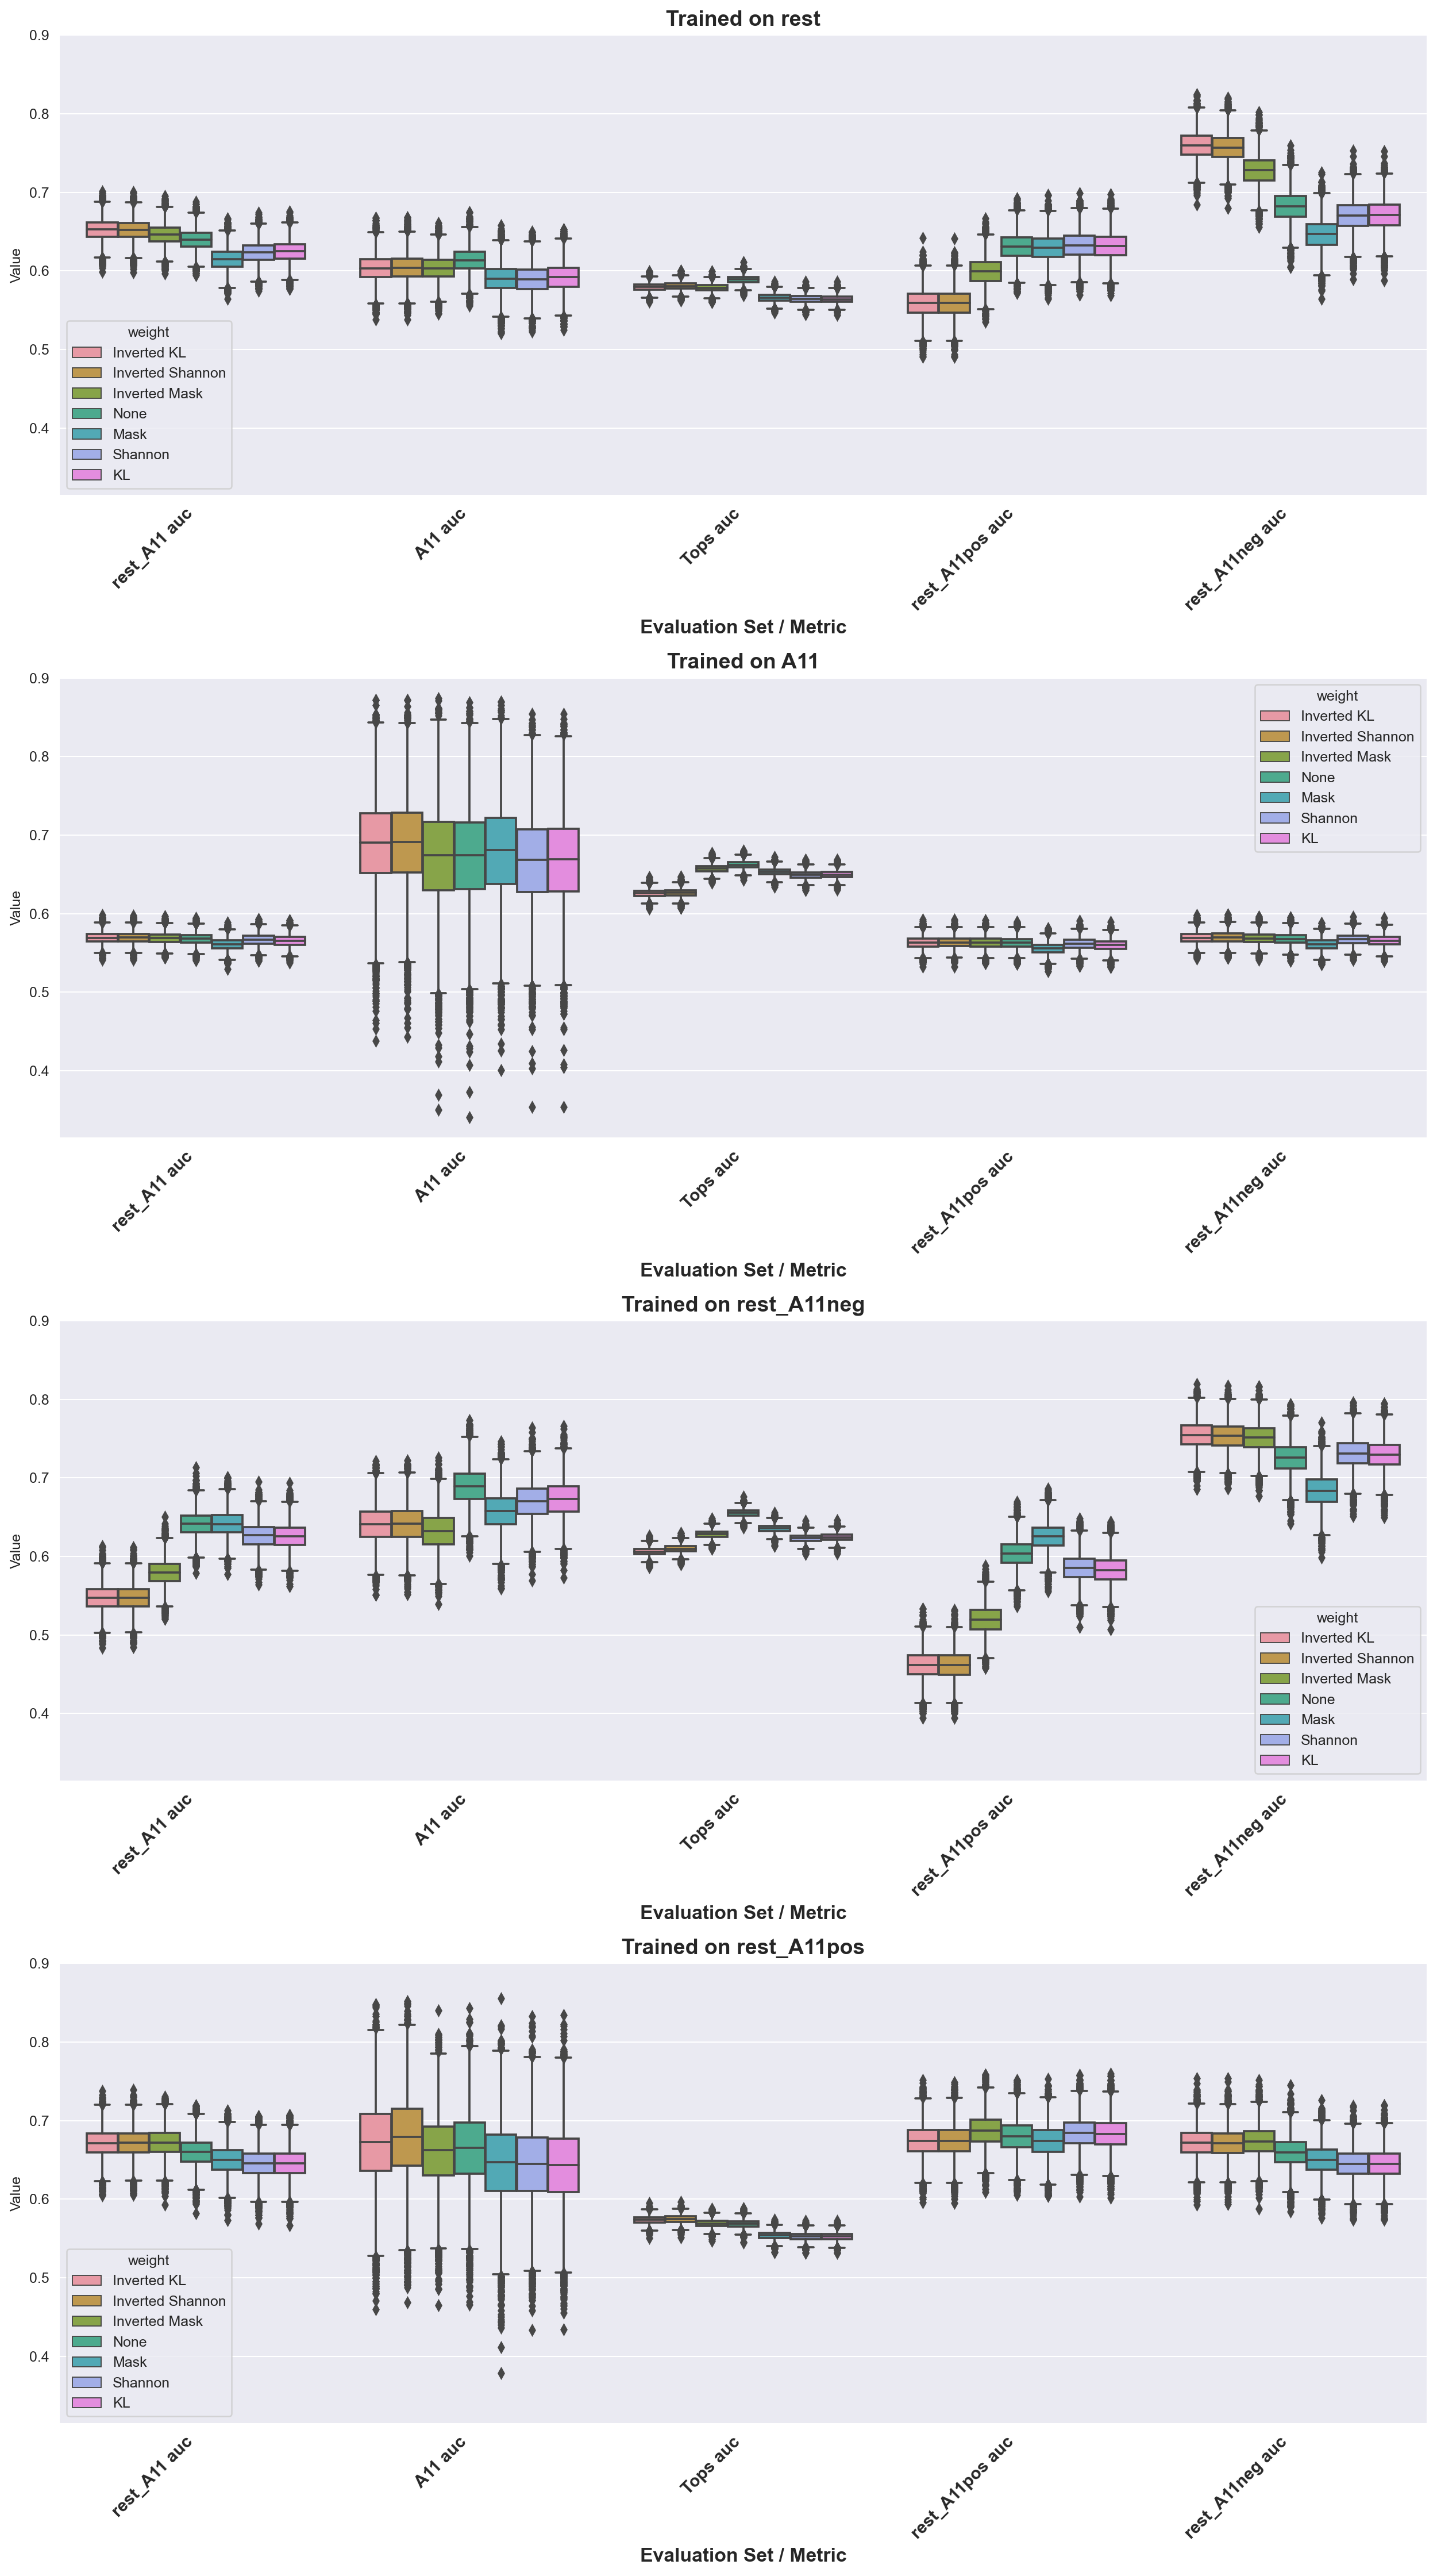

In [478]:
weight_order = ['Inverted KL', 'Inverted Shannon', 'Inverted Mask', 'None',
                'Mask', 'Shannon', 'KL']

f,a = plt.subplots(len(df_a11shuffle.trainset.unique()), 1, figsize=(14,int(6.25*len(df_a11shuffle.trainset.unique()))),
                   sharey=True)
# f.suptitle('xd',
#           fontweight='semibold', fontsize = 14.5)
for trainset, axis in zip(df_a11shuffle.trainset.unique(), a.ravel()):
    
    tmp_df = pd.melt(df_a11shuffle.query('trainset==@trainset'),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc'])
    
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'Trained on {trainset}', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12),
                        rotation=45, ha = 'right')
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')

f.tight_layout()
# f.savefig('../output/hla_analysis_fixed/boxplot_fulldataset_10-randomfolds.png',
#           dpi=200, bbox_inches='tight')